## Imports and setup

In [73]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import json
import os
import re
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

# Configuration - modify these paths as needed
IN_DIR = "/home/mvishiu11/Desktop/CERN/LHC-aging-analysis/data/physicsROOT/work/250720-122949/digits"
PHYSICS_RUN_JSON = "/home/mvishiu11/Desktop/CERN/LHC-aging-analysis/data/physicsROOT/physics_runs.json"

# Ring channel definitions
RINGS = {
    'Inner_A': (0, 31),
    'Outer_A': (32, 95), 
    'C': (96, 207),
    'All': (0, 207)
}

# Histogram binning
HIST_BINS = 4100
HIST_RANGE = (0, 4100)

print("Configuration loaded successfully!")
print(f"Data directory: {IN_DIR}")
print(f"Ring definitions: {RINGS}")

Configuration loaded successfully!
Data directory: /home/mvishiu11/Desktop/CERN/LHC-aging-analysis/data/physicsROOT/work/250720-122949/digits
Ring definitions: {'Inner_A': (0, 31), 'Outer_A': (32, 95), 'C': (96, 207), 'All': (0, 207)}


## Loading run config

In [37]:
def load_run_timestamps(json_file):
    """Load run timestamps, beam types, and polarity from physics_run.json file"""
    with open(json_file, 'r') as f:
        run_data = json.load(f)
    
    # Convert to dictionary for easy lookup: run_number -> run_info
    run_info = {}
    beam_configs = {}  # Track unique beam configurations
    
    for entry in run_data:
        run_num = entry['run']
        run_info[run_num] = {
            'timestamp': entry['start_ms'],
            'polarity': entry['polarity'],
            'beam_type': entry['beamType']
        }
        
        # Track beam configurations
        config_key = f"{entry['beamType']} ({entry['polarity']})"
        if config_key not in beam_configs:
            beam_configs[config_key] = []
        beam_configs[config_key].append(run_num)
    
    print(f"Loaded information for {len(run_info)} runs")
    print(f"Beam configurations found:")
    for config, runs in beam_configs.items():
        print(f"  {config}: {len(runs)} runs")
    
    return run_info, beam_configs

# Load the enhanced run data
run_info, beam_configurations = load_run_timestamps(PHYSICS_RUN_JSON)
print("\nSample run information:")
for i, (run, info) in enumerate(list(run_info.items())[:3]):
    dt = datetime.fromtimestamp(info['timestamp']/1000)
    print(f"  Run {run}: {dt} | {info['beam_type']} | {info['polarity']}")

Loaded information for 25 runs
Beam configurations found:
  NE10 - NE10 (POSITIVE): 3 runs
  O8 - O8 (POSITIVE): 13 runs
  PROTON - O8 (POSITIVE): 9 runs

Sample run information:
  Run 564472: 2025-07-09 00:08:15.222000 | NE10 - NE10 | POSITIVE
  Run 564470: 2025-07-08 23:44:30.690000 | NE10 - NE10 | POSITIVE
  Run 564468: 2025-07-08 16:30:15.282000 | NE10 - NE10 | POSITIVE


## Helper functions

In [77]:
def extract_run_number(filename):
    """Extract run number from filename like 'run_564250_ft0digits.root'"""
    match = re.search(r'run_(\d{6})_ft0digits\.root', filename)
    if match:
        return int(match.group(1))
    return None

def create_histogram_for_ring(tree, ring_name, channel_range):
    """Create histogram for a specific ring"""
    min_ch, max_ch = channel_range
    
    # Read the data with channel filter
    try:
        # Load branches using correct names from the ROOT file structure
        qtc_ampl = tree["FT0DIGITSCH/FT0DIGITSCH.QTCAmpl"].array(library="np")
        channel_id = tree["FT0DIGITSCH/FT0DIGITSCH.ChId"].array(library="np")
        
        # Flatten arrays and apply channel filter
        qtc_flat = np.concatenate(qtc_ampl)
        ch_flat = np.concatenate(channel_id)
        
        # Filter for ring channels
        mask = (ch_flat >= min_ch) & (ch_flat <= max_ch)
        filtered_qtc = qtc_flat[mask]
        
        # Create histogram
        hist, bin_edges = np.histogram(filtered_qtc, bins=HIST_BINS, range=HIST_RANGE)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        #print(f"  {ring_name}: {len(filtered_qtc)} entries, channels {min_ch}-{max_ch}")
        return hist, bin_centers
        
    except Exception as e:
        print(f"  Error creating histogram for {ring_name}: {e}")
        return None, None

def get_root_files(directory):
    """Get all .root files matching the pattern in directory"""
    files = []
    for file in Path(directory).glob("run_*_ft0digits.root"):
        run_num = extract_run_number(file.name)
        if run_num:
            files.append((str(file), run_num))
    
    # Sort by run number
    files.sort(key=lambda x: x[1])
    print(f"Found {len(files)} ROOT files")
    return files

In [75]:
def gaussian(x, amplitude, mean, sigma):
    """Gaussian function for fitting"""
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * sigma ** 2))

def fit_fractional_gaussian(hist, bin_centers):
    """
    Fit Gaussian to fractional range around peak (0.75x to 1.25x of peak position)
    Returns fitted mean or None if fit fails
    """
    try:
        # Find peak position
        peak_idx = np.argmax(hist)
        peak_pos = bin_centers[peak_idx]
        
        # Define fitting range (0.75x to 1.25x of peak position)
        fit_min = 0.75 * peak_pos
        fit_max = 1.25 * peak_pos
        
        # Create mask for fitting range
        mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
        
        # Proceed with fitting even with few points - MIP peak is the signal of interest
        if np.sum(mask) < 3:  # Need at least 3 points for 3-parameter fit
            print(f"    Too few points for Gaussian fit: {np.sum(mask)} points")
            return None
            
        x_fit = bin_centers[mask]
        y_fit = hist[mask]
        
        # Remove any zero or negative values
        valid_mask = y_fit > 0
        if np.sum(valid_mask) < 3:
            print(f"    Not enough positive values for Gaussian fit")
            return None
            
        x_fit = x_fit[valid_mask]
        y_fit = y_fit[valid_mask]
        
        # Initial parameter guesses
        amplitude_guess = np.max(y_fit)
        mean_guess = peak_pos
        sigma_guess = max(0.5, (fit_max - fit_min) / 6)  # Ensure reasonable sigma
        
        # Perform fit with bounds to prevent unreasonable parameters
        bounds = (
            [0, fit_min * 0.8, 0.1],  # Lower bounds: [amplitude, mean, sigma]
            [10*amplitude_guess, fit_max * 1.2, (fit_max - fit_min) * 2]  # Upper bounds
        )
        
        popt, pcov = curve_fit(gaussian, x_fit, y_fit, 
                              p0=[amplitude_guess, mean_guess, sigma_guess],
                              bounds=bounds,
                              maxfev=2000)
        
        fitted_mean = popt[1]
        fitted_sigma = popt[2]
        
        # Basic sanity check on fitted parameters
        if fitted_sigma > 0.1 and fitted_mean > 0:
            #print(f"    Gaussian fit: mean={fitted_mean:.2f}, sigma={fitted_sigma:.2f}")
            return fitted_mean
        else:
            print(f"    Gaussian parameters unreasonable: mean={fitted_mean:.2f}, sigma={fitted_sigma:.2f}")
            return None
        
    except Exception as e:
        print(f"    Gaussian fitting failed: {e}")
        return None

def fit_weighted_average(hist, bin_centers):
    """
    Calculate weighted average in fractional range around peak (0.75x to 1.25x of peak position)
    This is more robust than Gaussian fitting for non-perfect peak shapes
    Returns weighted average position or None if calculation fails
    """
    try:
        # Find peak position
        peak_idx = np.argmax(hist)
        peak_pos = bin_centers[peak_idx]
        
        # Define same fitting range as Gaussian (0.75x to 1.25x of peak position)
        fit_min = 0.75 * peak_pos
        fit_max = 1.25 * peak_pos
        
        # Create mask for fitting range
        mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
        
        if np.sum(mask) < 2:  # Need at least 2 points
            print(f"    Too few points for weighted average: {np.sum(mask)} points")
            return None
            
        x_range = bin_centers[mask]
        y_range = hist[mask]
        
        # Remove zero or negative values
        valid_mask = y_range > 0
        if np.sum(valid_mask) < 2:
            print(f"    Not enough positive values for weighted average")
            return None
            
        x_valid = x_range[valid_mask]
        y_valid = y_range[valid_mask]
        
        # Calculate weighted average: sum(x_i * w_i) / sum(w_i)
        weighted_average = np.sum(x_valid * y_valid) / np.sum(y_valid)
        
        # Sanity check
        if fit_min <= weighted_average <= fit_max:
            #print(f"    Weighted average: {weighted_average:.2f}")
            return weighted_average
        else:
            print(f"    Weighted average out of range: {weighted_average:.2f}")
            return None
        
    except Exception as e:
        print(f"    Weighted average calculation failed: {e}")
        return None

## Main processing

In [78]:
def process_all_files():
    """Process all ROOT files and extract fitted means for each ring"""
    
    # Get list of files
    root_files = get_root_files(IN_DIR)
    
    if not root_files:
        tqdm.write("No ROOT files found!")
        return None

    num_files = len(root_files)
    
    # Initialize results storage
    results = {
        'run_numbers': [],
        'timestamps': [],
        'beam_types': [],
        'polarities': [],
        'Inner_A_mean_gauss': [],
        'Outer_A_mean_gauss': [],
        'C_mean_gauss': [],
        'All_mean_gauss': [],
        'Inner_A_mean_weighted': [],
        'Outer_A_mean_weighted': [],
        'C_mean_weighted': [],
        'All_mean_weighted': []
    }
    
    #tqdm.write("\nProcessing files...")
    
    for (filepath, run_num) in tqdm(root_files, desc="Processing ROOT files"):
        
        # Check if we have timestamp for this run
        if run_num not in run_timestamps:
            tqdm.write(f"  Warning: No timestamp found for run {run_num}, skipping")
            continue
        
        try:
            # Open ROOT file
            with uproot.open(filepath) as file:
                tree = file["o2sim"]
                
                # Process each ring
                ring_means = {}
                for ring_name, channel_range in RINGS.items():
                    hist, bin_centers = create_histogram_for_ring(tree, ring_name, channel_range)
                    
                    if hist is not None:
                        fitted_mean_gauss = fit_fractional_gaussian(hist, bin_centers)
                        fitted_mean_weighted = fit_weighted_average(hist, bin_centers)
                        ring_means[ring_name + '_gauss'] = fitted_mean_gauss
                        #ring_means[ring_name + '_weighted'] = fitted_mean_weighted
                        #tqdm.write(f"    {ring_name} fitted Gaussian mean: {fitted_mean_gauss}")
                        #tqdm.write(f"    {ring_name} fitted weighted mean: {fitted_mean_weighted}")
                    else:
                        ring_means[ring_name] = None
                        #tqdm.write(f"    {ring_name}: Failed to create histogram")
                
                # Store results
                results['run_numbers'].append(run_num)
                results['timestamps'].append(run_info[run_num]['timestamp'])
                results['beam_types'].append(run_info[run_num]['beam_type'])
                results['polarities'].append(run_info[run_num]['polarity'])
                results['Inner_A_mean_gauss'].append(ring_means['Inner_A_gauss'])
                results['Outer_A_mean_gauss'].append(ring_means['Outer_A_gauss']) 
                results['C_mean_gauss'].append(ring_means['C_gauss'])
                results['All_mean_gauss'].append(ring_means['All_gauss'])
                #results['Inner_A_mean_weighted'].append(ring_means['Inner_A_weighted'])
                #results['Outer_A_mean_weighted'].append(ring_means['Outer_A_weighted']) 
                #results['C_mean_weighted'].append(ring_means['C_weighted'])
                #results['All_mean_weighted'].append(ring_means['All_weighted'])
                
        except Exception as e:
            tqdm.write(f"  Error processing file {filepath}: {e}")
            continue
            
    return results

# Debug Cell - Add this before running the main processing
def debug_histogram(filepath, run_num):
    """Debug function to examine one histogram in detail"""
    print(f"Debugging run {run_num}...")
    
    try:
        with uproot.open(filepath) as file:
            tree = file["o2sim"]
            
            # Load data for Inner_A ring
            qtc_ampl = tree["FT0DIGITSCH/FT0DIGITSCH.QTCAmpl"].array(library="np")
            channel_id = tree["FT0DIGITSCH/FT0DIGITSCH.ChId"].array(library="np")
            
            # Flatten arrays
            qtc_flat = np.concatenate(qtc_ampl)
            ch_flat = np.concatenate(channel_id)
            
            # Filter for Inner_A (channels 0-31)
            mask = (ch_flat >= 0) & (ch_flat <= 31)
            filtered_qtc = qtc_flat[mask]
            
            print(f"Total entries after channel filter: {len(filtered_qtc)}")
            print(f"QTC amplitude range: {filtered_qtc.min():.2f} - {filtered_qtc.max():.2f}")
            print(f"QTC amplitude mean: {filtered_qtc.mean():.2f}")
            
            # Create histogram
            hist, bin_edges = np.histogram(filtered_qtc, bins=HIST_BINS, range=HIST_RANGE)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Find peak
            peak_idx = np.argmax(hist)
            peak_pos = bin_centers[peak_idx]
            peak_value = hist[peak_idx]
            
            print(f"Peak position: {peak_pos:.2f}")
            print(f"Peak value: {peak_value}")
            print(f"Non-zero bins: {np.sum(hist > 0)}")
            
            # Check fitting range
            fit_min = 0.75 * peak_pos
            fit_max = 1.25 * peak_pos
            fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
            
            print(f"Fitting range: {fit_min:.2f} - {fit_max:.2f}")
            print(f"Points in fitting range: {np.sum(fit_mask)}")
            
            if np.sum(fit_mask) > 0:
                x_fit = bin_centers[fit_mask]
                y_fit = hist[fit_mask]
                print(f"Fit data range - x: {x_fit.min():.2f} to {x_fit.max():.2f}")
                print(f"Fit data range - y: {y_fit.min()} to {y_fit.max()}")
            
            # Plot the histogram for visual inspection
            plt.figure(figsize=(10, 6))
            plt.plot(bin_centers, hist, 'b-', alpha=0.7, label='Histogram')
            plt.axvline(peak_pos, color='r', linestyle='--', label=f'Peak at {peak_pos:.1f}')
            plt.axvline(fit_min, color='g', linestyle=':', label=f'Fit range')
            plt.axvline(fit_max, color='g', linestyle=':', )
            plt.xlabel('QTC Amplitude')
            plt.ylabel('Counts')
            plt.title(f'Debug: Inner_A Ring Histogram - Run {run_num}')
            plt.legend()
            plt.yscale('log')  # Use log scale to see small values
            plt.grid(True, alpha=0.3)
            plt.show()
            
    except Exception as e:
        print(f"Debug error: {e}")

# Debug the first file
#root_files = get_root_files(IN_DIR)
#if root_files:
#    first_file, first_run = root_files[0]
#    debug_histogram(first_file, first_run)

# Run the processing
results = process_all_files()

Found 17 ROOT files


Processing ROOT files:   0%|          | 0/17 [00:00<?, ?it/s]

## First visualization

Inner_A: 17 points, normalization factor: 13.79
Outer_A: 17 points, normalization factor: 13.79
C: 17 points, normalization factor: 13.96


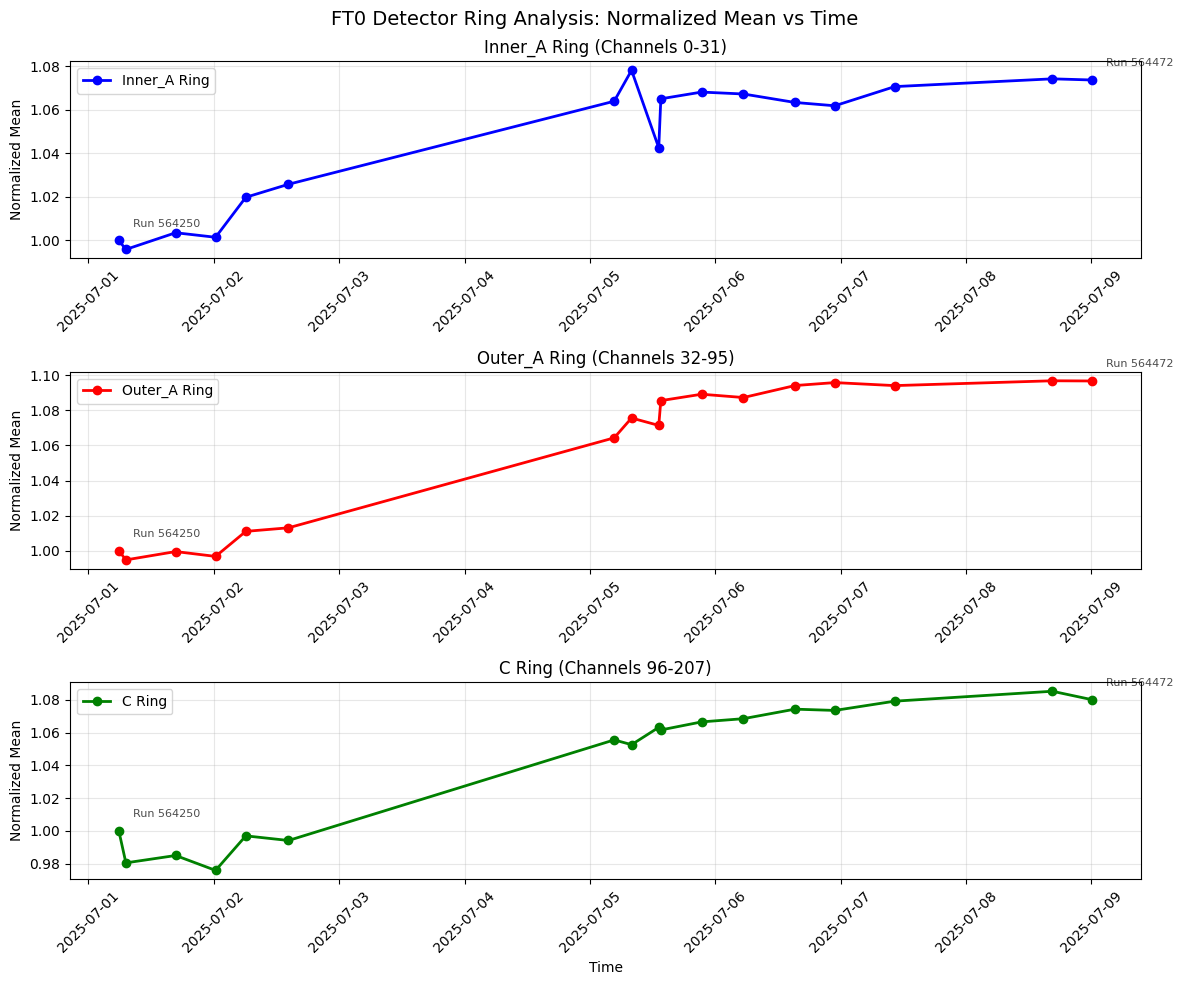


Summary Statistics:
--------------------------------------------------
Inner_A Ring:
  Mean normalization factor: 13.79
  Normalized range: 0.9959 - 1.0780
  Standard deviation: 0.0296

Outer_A Ring:
  Mean normalization factor: 13.79
  Normalized range: 0.9948 - 1.0969
  Standard deviation: 0.0412

C Ring:
  Mean normalization factor: 13.96
  Normalized range: 0.9758 - 1.0853
  Standard deviation: 0.0396



In [52]:
def normalize_and_plot_results(results):
    """Normalize means to first run and create time series plots"""
    
    if not results or len(results['run_numbers']) == 0:
        print("No results to plot!")
        return
    
    # Convert to arrays for easier handling
    run_numbers = np.array(results['run_numbers'])
    timestamps = np.array(results['timestamps'])
    
    # Convert timestamps to datetime objects
    datetimes = [datetime.fromtimestamp(ts/1000) for ts in timestamps]
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    fig.suptitle('FT0 Detector Ring Analysis: Normalized Mean vs Time', fontsize=14)
    
    ring_names = ['Inner_A', 'Outer_A', 'C']
    colors = ['blue', 'red', 'green']
    
    for i, (ring_name, color) in enumerate(zip(ring_names, colors)):
        means = np.array(results[f'{ring_name}_mean'])
        
        # Remove None values
        valid_mask = means != None
        if not np.any(valid_mask):
            print(f"No valid data for {ring_name}")
            continue
            
        valid_means = means[valid_mask].astype(float)
        valid_times = np.array(datetimes)[valid_mask]
        valid_runs = run_numbers[valid_mask]
        
        # Normalize to first run
        if len(valid_means) > 0:
            normalized_means = valid_means / valid_means[0]
            
            # Plot
            axes[i].plot(valid_times, normalized_means, 'o-', color=color, 
                        markersize=6, linewidth=2, label=f'{ring_name} Ring')
            axes[i].set_ylabel('Normalized Mean')
            axes[i].set_title(f'{ring_name} Ring (Channels {RINGS[ring_name][0]}-{RINGS[ring_name][1]})')
            axes[i].grid(True, alpha=0.3)
            axes[i].legend()
            
            # Add run numbers as annotations for first and last points
            if len(valid_runs) > 0:
                axes[i].annotate(f'Run {valid_runs[0]}', 
                               (valid_times[0], normalized_means[0]),
                               xytext=(10, 10), textcoords='offset points',
                               fontsize=8, alpha=0.7)
                if len(valid_runs) > 1:
                    axes[i].annotate(f'Run {valid_runs[-1]}', 
                                   (valid_times[-1], normalized_means[-1]),
                                   xytext=(10, 10), textcoords='offset points',
                                   fontsize=8, alpha=0.7)
            
            print(f"{ring_name}: {len(valid_means)} points, normalization factor: {valid_means[0]:.2f}")
    
    # Format x-axis
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
    
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("-" * 50)
    for ring_name in ring_names:
        means = np.array(results[f'{ring_name}_mean'])
        valid_means = means[means != None].astype(float)
        if len(valid_means) > 0:
            normalized = valid_means / valid_means[0]
            print(f"{ring_name} Ring:")
            print(f"  Mean normalization factor: {valid_means[0]:.2f}")
            print(f"  Normalized range: {normalized.min():.4f} - {normalized.max():.4f}")
            print(f"  Standard deviation: {normalized.std():.4f}")
            print()

# Create the plots
normalize_and_plot_results(results)

## Ring visualization - EDIT: for all runs, does not make sense?

🎨 Creating FT0 Ring Aging Visualizations...
   Creating Plot 1: Time Series...
   Creating Plot 2: Ring Layout...
   Creating Plot 3: Bar Comparison...


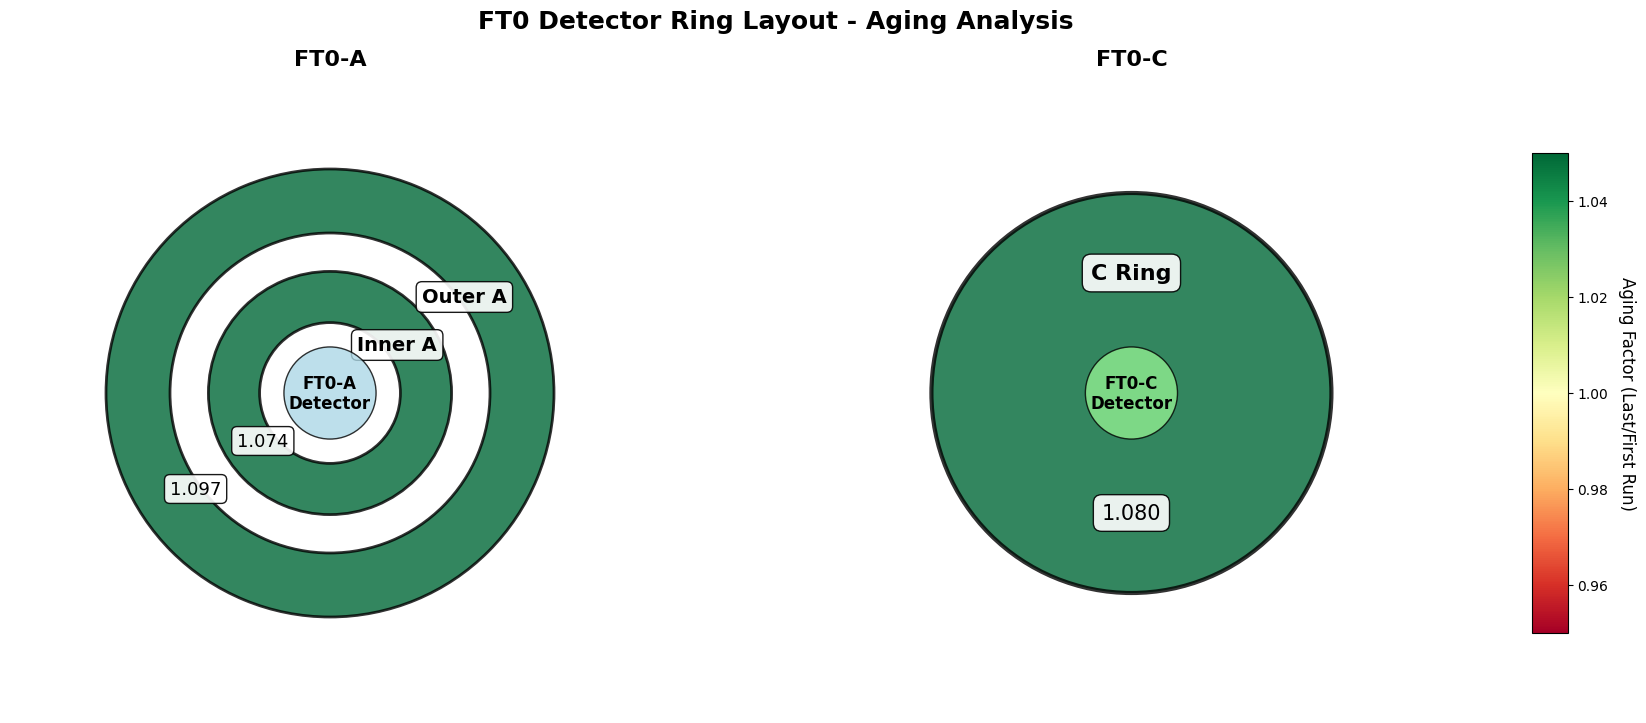

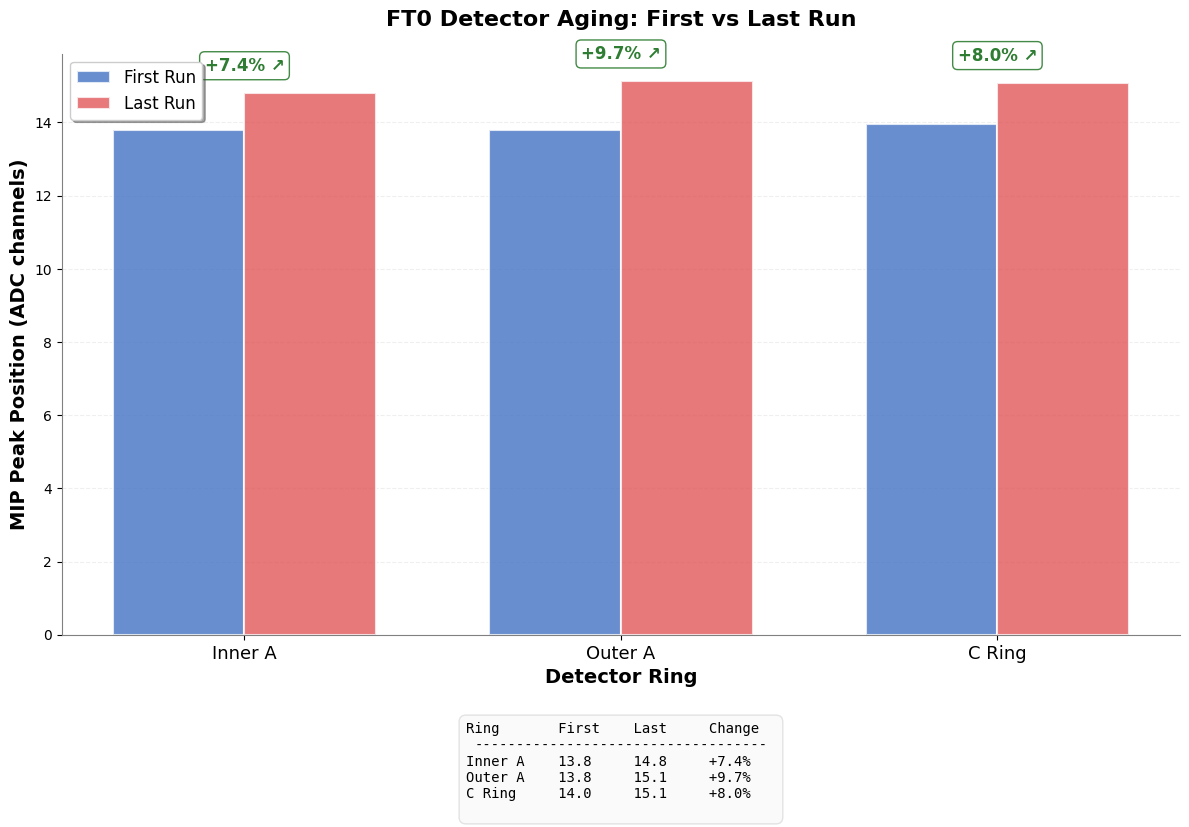

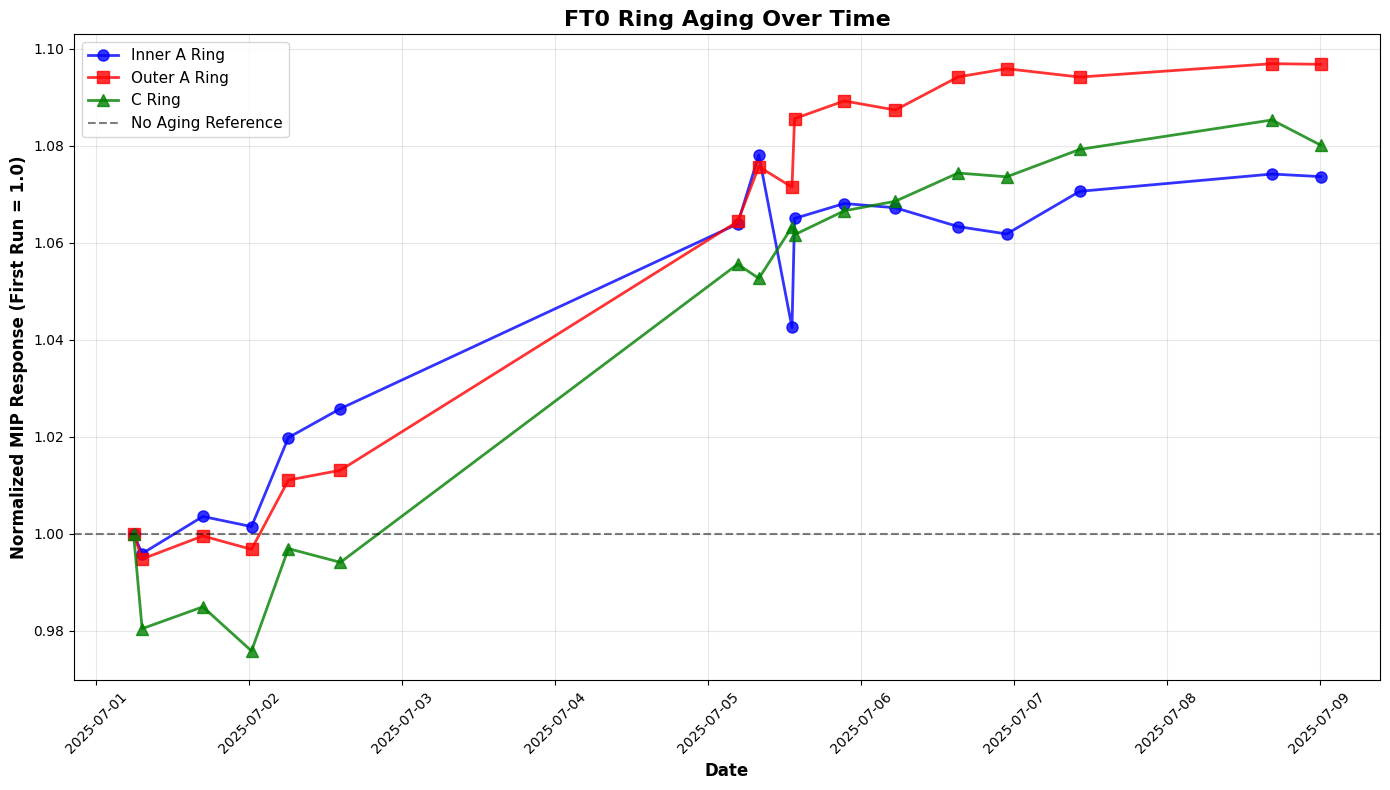

   ✅ Plot 1: Time series displayed


<Figure size 640x480 with 0 Axes>

   ✅ Plot 2: Ring layout displayed


<Figure size 640x480 with 0 Axes>

   ✅ Plot 3: Bar comparison displayed

FT0 RING AGING ANALYSIS - COMPREHENSIVE SUMMARY

📊 Dataset Information:
   Total runs processed: 17
   Time range: 2025-07-01 to 2025-07-09
   Duration: 7.8 days

🔬 Ring Analysis:

   Inner A:
      Valid runs: 17
      First run MIP: 13.79
      Last run MIP: 14.80
      Aging factor: 1.0736
      Change: +7.36%
      Stability (σ): 0.408
      Status: 🔵 IMPROVED

   Outer A:
      Valid runs: 17
      First run MIP: 13.79
      Last run MIP: 15.13
      Aging factor: 1.0967
      Change: +9.67%
      Stability (σ): 0.569
      Status: 🔵 IMPROVED

   C Ring:
      Valid runs: 17
      First run MIP: 13.96
      Last run MIP: 15.08
      Aging factor: 1.0801
      Change: +8.01%
      Stability (σ): 0.553
      Status: 🔵 IMPROVED

🎯 Physics Interpretation:
   • A-side faces collision point (high radiation)
   • C-side faces muon arm (different environment)
   • Inner rings more sensitive to radiation damage
   • MIP peak shifts indicate detector r

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize
import numpy as np
from datetime import datetime

def extract_ring_data(results):
    """Extract and process ring data from results"""
    ring_data = {}
    ring_names = ['Inner_A', 'Outer_A', 'C']
    
    for ring_name in ring_names:
        means = np.array(results[f'{ring_name}_mean'])
        
        # Remove None values
        valid_mask = means != None
        if not np.any(valid_mask):
            ring_data[ring_name] = {'aging_factor': 1.0, 'n_points': 0, 'std': 0.0, 'means': []}
            continue
            
        valid_means = means[valid_mask].astype(float)
        
        if len(valid_means) > 0:
            # Calculate aging factor (last/first)
            aging_factor = valid_means[-1] / valid_means[0] if valid_means[0] != 0 else 1.0
            ring_data[ring_name] = {
                'aging_factor': aging_factor,
                'n_points': len(valid_means),
                'std': np.std(valid_means),
                'mean_value': np.mean(valid_means),
                'means': valid_means,
                'first_value': valid_means[0],
                'last_value': valid_means[-1]
            }
        else:
            ring_data[ring_name] = {'aging_factor': 1.0, 'n_points': 0, 'std': 0.0, 'means': []}
    
    return ring_data

def plot1_time_series(results):
    """Plot 1: Combined aging over time (line plot)"""
    if not results or len(results['run_numbers']) == 0:
        print("No results for time series!")
        return None
    
    # Convert timestamps to datetime
    timestamps = [datetime.fromtimestamp(ts/1000) for ts in results['timestamps']]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ring_names = ['Inner_A', 'Outer_A', 'C']
    colors = ['blue', 'red', 'green']
    markers = ['o', 's', '^']
    
    for ring_name, color, marker in zip(ring_names, colors, markers):
        means = np.array(results[f'{ring_name}_mean'])
        
        # Remove None values
        valid_mask = means != None
        if not np.any(valid_mask):
            continue
            
        valid_means = means[valid_mask].astype(float)
        valid_times = np.array(timestamps)[valid_mask]
        
        if len(valid_means) > 0:
            # Normalize to first run
            normalized_means = valid_means / valid_means[0]
            
            ax.plot(valid_times, normalized_means, color=color, 
                   markersize=8, linewidth=2, label=f'{ring_name.replace("_", " ")} Ring',
                   marker=marker, alpha=0.8, linestyle='-')
    
    ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='No Aging Reference')
    ax.set_ylabel('Normalized MIP Response (First Run = 1.0)', fontweight='bold', fontsize=12)
    ax.set_xlabel('Date', fontweight='bold', fontsize=12)
    ax.set_title('FT0 Ring Aging Over Time', fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

def plot2_ring_layout(results):
    """Plot 2: Ring-based layout with A and C side subplots"""
    ring_data = extract_ring_data(results)
    
    # Set up colormap
    cmap = plt.get_cmap('RdYlGn')  # Red=bad, Green=good
    norm = Normalize(vmin=0.95, vmax=1.05)  # 5% range around 1.0
    
    # Create figure with 2 subplots side by side
    fig = plt.figure(figsize=(18, 8))
    
    # --- A-SIDE SUBPLOT ---
    ax1 = plt.subplot(121)
    
    # Ring positions for A-side (concentric)
    a_ring_positions = {
        'Inner_A': {'center': (0, 0), 'radius': 1.5, 'width': 0.8},
        'Outer_A': {'center': (0, 0), 'radius': 3.0, 'width': 1.0}
    }
    
    # Draw A-side rings
    a_rings = ['Inner_A', 'Outer_A']
    for ring_name in a_rings:
        pos = a_ring_positions[ring_name]
        factor = ring_data[ring_name]['aging_factor']
        n_points = ring_data[ring_name]['n_points']
        
        if n_points == 0:
            color = 'gray'
            alpha = 0.5
        else:
            color = cmap(norm(factor))
            alpha = 0.8
        
        # Draw ring as an annulus
        ring = patches.Wedge(pos['center'], pos['radius'] + pos['width']/2, 0, 360, 
                           width=pos['width'], facecolor=color, 
                           edgecolor='black', linewidth=2, alpha=alpha)
        ax1.add_patch(ring)
        
        # Add text labels
        label_radius = pos['radius']
        
        # Ring name
        ax1.text(label_radius * 0.7, label_radius * 0.5, ring_name.replace('_', ' '), 
                fontsize=14, fontweight='bold', ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))
        
        # Aging factor
        if n_points > 0:
            ax1.text(label_radius * -0.7, label_radius * -0.5, 
                    f'{factor:.3f}', fontsize=13, ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))
        else:
            ax1.text(label_radius * -0.7, label_radius * -0.5, 
                    'No Data', fontsize=11, ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.9))
    
    # Style A-side plot
    ax1.set_xlim(-5, 5)
    ax1.set_ylim(-5, 5)
    ax1.set_aspect('equal')
    ax1.set_title('FT0-A', fontsize=16, fontweight='bold')
    ax1.axis('off')
    
    # Add center label for A-side
    ax1.text(0, 0, 'FT0-A\nDetector', ha='center', va='center', 
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='circle,pad=0.3', facecolor='lightblue', alpha=0.8))
    
    # --- C-SIDE SUBPLOT ---
    ax2 = plt.subplot(122)
    
    # C-side single ring
    c_factor = ring_data['C']['aging_factor']
    c_n_points = ring_data['C']['n_points']
    
    if c_n_points == 0:
        c_color = 'gray'
        alpha = 0.5
    else:
        c_color = cmap(norm(c_factor))
        alpha = 0.8
    
    # Draw C-side as single large ring
    c_ring = patches.Circle((0, 0), 2.5, facecolor=c_color, 
                           edgecolor='black', linewidth=3, alpha=alpha)
    ax2.add_patch(c_ring)
    
    # Add C-side labels
    ax2.text(0, 1.5, 'C Ring', fontsize=16, fontweight='bold', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))
    
    if c_n_points > 0:
        ax2.text(0, -1.5, f'{c_factor:.3f}', fontsize=15, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))
    else:
        ax2.text(0, -1.5, 'No Data', fontsize=13, ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgray', alpha=0.9))
    
    # Style C-side plot
    ax2.set_xlim(-4, 4)
    ax2.set_ylim(-4, 4)
    ax2.set_aspect('equal')
    ax2.set_title('FT0-C', fontsize=16, fontweight='bold')
    ax2.axis('off')
    
    # Add center label for C-side
    ax2.text(0, 0, 'FT0-C\nDetector', ha='center', va='center', 
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='circle,pad=0.3', facecolor='lightgreen', alpha=0.8))
    
    # Add shared colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    # Position colorbar between subplots
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Aging Factor (Last/First Run)', rotation=270, labelpad=20, fontsize=12)
    
    # Add main title
    fig.suptitle('FT0 Detector Ring Layout - Aging Analysis', fontsize=18, fontweight='bold')
    
    # Manual layout adjustment to avoid warnings
    plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.1)
    
    return fig

def plot3_bar_comparison(results):
    """Plot 3: Clean bar plot comparing first vs last run values"""
    ring_data = extract_ring_data(results)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Prepare data
    ring_names = ['Inner_A', 'Outer_A', 'C']
    display_names = ['Inner A', 'Outer A', 'C Ring']
    
    first_values = []
    last_values = []
    aging_factors = []
    
    for ring_name in ring_names:
        data = ring_data[ring_name]
        if data['n_points'] > 0:
            first_values.append(data['first_value'])
            last_values.append(data['last_value'])
            aging_factors.append(data['aging_factor'])
        else:
            first_values.append(0)
            last_values.append(0)
            aging_factors.append(1.0)
    
    # Set up bar positions
    x = np.arange(len(display_names))
    width = 0.35
    
    # Use cleaner color scheme
    first_color = '#4472C4'  # Professional blue
    last_color = '#E15759'   # Professional red/coral
    
    # Create bars with cleaner styling
    bars1 = ax.bar(x - width/2, first_values, width, label='First Run', 
                   color=first_color, alpha=0.8, edgecolor='white', linewidth=1.5)
    bars2 = ax.bar(x + width/2, last_values, width, label='Last Run', 
                   color=last_color, alpha=0.8, edgecolor='white', linewidth=1.5)
    
    # Add only the aging percentage above each pair of bars
    for i, ring_name in enumerate(ring_names):
        data = ring_data[ring_name]
        if data['n_points'] > 0:
            first = first_values[i]
            last = last_values[i]
            change_pct = (aging_factors[i] - 1.0) * 100
            
            # Position percentage annotation above the taller bar
            max_height = max(first, last)
            
            # Color-code the percentage based on change
            if change_pct > 1:
                pct_color = '#2E7D32'  # Green for improvement
                arrow = '↗'
            elif change_pct < -1:
                pct_color = '#D32F2F'  # Red for degradation
                arrow = '↘' 
            else:
                pct_color = '#1976D2'  # Blue for stable
                arrow = '→'
            
            # Single clean annotation per ring
            ax.text(i, max_height + 0.5, f'{change_pct:+.1f}% {arrow}', 
                   ha='center', va='bottom', fontweight='bold', fontsize=12,
                   color=pct_color,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                           edgecolor=pct_color, alpha=0.9))
        else:
            ax.text(i, 5, 'No Data Available', ha='center', va='center', 
                   fontsize=12, color='gray', fontweight='bold')
    
    # Clean styling
    ax.set_xlabel('Detector Ring', fontweight='bold', fontsize=14)
    ax.set_ylabel('MIP Peak Position (ADC channels)', fontweight='bold', fontsize=14)
    ax.set_title('FT0 Detector Aging: First vs Last Run', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(display_names, fontsize=13)
    
    # Cleaner legend
    ax.legend(loc='upper left', fontsize=12, frameon=True, fancybox=True, shadow=True)
    
    # Subtle grid
    ax.grid(True, alpha=0.2, axis='y', linestyle='--')
    ax.set_axisbelow(True)
    
    # Clean up axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    
    # Add summary table at bottom instead of overlaid text
    if any(ring_data[name]['n_points'] > 0 for name in ring_names):
        # Create a simple summary table below the plot
        summary_data = []
        for ring_name, display_name in zip(ring_names, display_names):
            data = ring_data[ring_name]
            if data['n_points'] > 0:
                change_pct = (data['aging_factor'] - 1.0) * 100
                first = data['first_value']
                last = data['last_value']
                summary_data.append([display_name, f'{first:.1f}', f'{last:.1f}', f'{change_pct:+.1f}%'])
            else:
                summary_data.append([display_name, 'N/A', 'N/A', 'N/A'])
        
        # Add table text below plot
        table_text = f"{'Ring':<10} {'First':<8} {'Last':<8} {'Change':<8}\n" + "-"*35 + "\n"
        for row in summary_data:
            table_text += f"{row[0]:<10} {row[1]:<8} {row[2]:<8} {row[3]:<8}\n"
        
        # Position table below the x-axis
        ax.text(0.5, -0.15, table_text, transform=ax.transAxes, fontsize=10,
                ha='center', va='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.1))
    
    plt.tight_layout()
    
    # Adjust layout to accommodate table
    plt.subplots_adjust(bottom=0.2)
    
    return fig

def print_summary_statistics(results):
    """Print comprehensive summary statistics"""
    ring_data = extract_ring_data(results)
    
    print("\n" + "="*70)
    print("FT0 RING AGING ANALYSIS - COMPREHENSIVE SUMMARY")
    print("="*70)
    
    print(f"\n📊 Dataset Information:")
    print(f"   Total runs processed: {len(results['run_numbers'])}")
    if results['timestamps']:
        start_time = datetime.fromtimestamp(min(results['timestamps'])/1000)
        end_time = datetime.fromtimestamp(max(results['timestamps'])/1000)
        print(f"   Time range: {start_time.strftime('%Y-%m-%d')} to {end_time.strftime('%Y-%m-%d')}")
        duration = (max(results['timestamps']) - min(results['timestamps'])) / (1000 * 86400)  # days
        print(f"   Duration: {duration:.1f} days")
    
    print(f"\n🔬 Ring Analysis:")
    ring_names = ['Inner_A', 'Outer_A', 'C']
    display_names = ['Inner A', 'Outer A', 'C Ring']
    
    for ring_name, display_name in zip(ring_names, display_names):
        data = ring_data[ring_name]
        print(f"\n   {display_name}:")
        if data['n_points'] > 0:
            print(f"      Valid runs: {data['n_points']}")
            print(f"      First run MIP: {data['first_value']:.2f}")
            print(f"      Last run MIP: {data['last_value']:.2f}") 
            print(f"      Aging factor: {data['aging_factor']:.4f}")
            change_pct = (data['aging_factor'] - 1.0) * 100
            print(f"      Change: {change_pct:+.2f}%")
            print(f"      Stability (σ): {data['std']:.3f}")
            
            # Status assessment
            if abs(change_pct) < 1:
                status = "🟢 STABLE"
            elif change_pct < -1:
                status = "🔴 DEGRADED" 
            else:
                status = "🔵 IMPROVED"
            print(f"      Status: {status}")
        else:
            print(f"      Status: ❌ NO DATA")
    
    print(f"\n🎯 Physics Interpretation:")
    print(f"   • A-side faces collision point (high radiation)")
    print(f"   • C-side faces muon arm (different environment)")  
    print(f"   • Inner rings more sensitive to radiation damage")
    print(f"   • MIP peak shifts indicate detector response changes")
    print(f"   • Aging factor = Last_run_MIP / First_run_MIP")
    
    print("="*70)

# Main execution function
def create_all_ft0_visualizations(results):
    """Create all three FT0 visualization plots"""
    
    if not results or len(results['run_numbers']) == 0:
        print("❌ No results to visualize!")
        return None, None, None
    
    print("🎨 Creating FT0 Ring Aging Visualizations...")
    print("   Creating Plot 1: Time Series...")
    fig1 = plot1_time_series(results)
    
    print("   Creating Plot 2: Ring Layout...")  
    fig2 = plot2_ring_layout(results)
    
    print("   Creating Plot 3: Bar Comparison...")
    fig3 = plot3_bar_comparison(results)
    
    # Display all plots
    if fig1:
        plt.figure(fig1.number)
        plt.show()
        print("   ✅ Plot 1: Time series displayed")
    
    if fig2:
        plt.figure(fig2.number)
        plt.show() 
        print("   ✅ Plot 2: Ring layout displayed")
    
    if fig3:
        plt.figure(fig3.number)
        plt.show()
        print("   ✅ Plot 3: Bar comparison displayed")
    
    # Print comprehensive summary
    print_summary_statistics(results)
    
    print("\n🎉 All visualizations complete!")
    return fig1, fig2, fig3

# Run all visualizations
if 'results' in locals():
    fig1, fig2, fig3 = create_all_ft0_visualizations(results)
else:
    print("❌ Please run the main analysis first to generate 'results' variable")
    print("   This visualization requires the output from Cell 5 (process_all_files)")

## Per Beam Type & Polarity config plots

Creating fancy plots for 3 beam configurations...
Creating plot for PROTON - O8 (POSITIVE) (6 runs)
  Raw timestamps: [1751341777720, 1751346650887, 1751380945841]...
  Converted timestamps: 2025-07-01 05:49:37.720000 to 2025-07-02 14:17:55.792000
  Time span: 1 days
  Plot time range: 2025-07-01 05:49:37.720000 to 2025-07-02 14:17:55.792000
  Y-axis range: 0.926 to 1.076


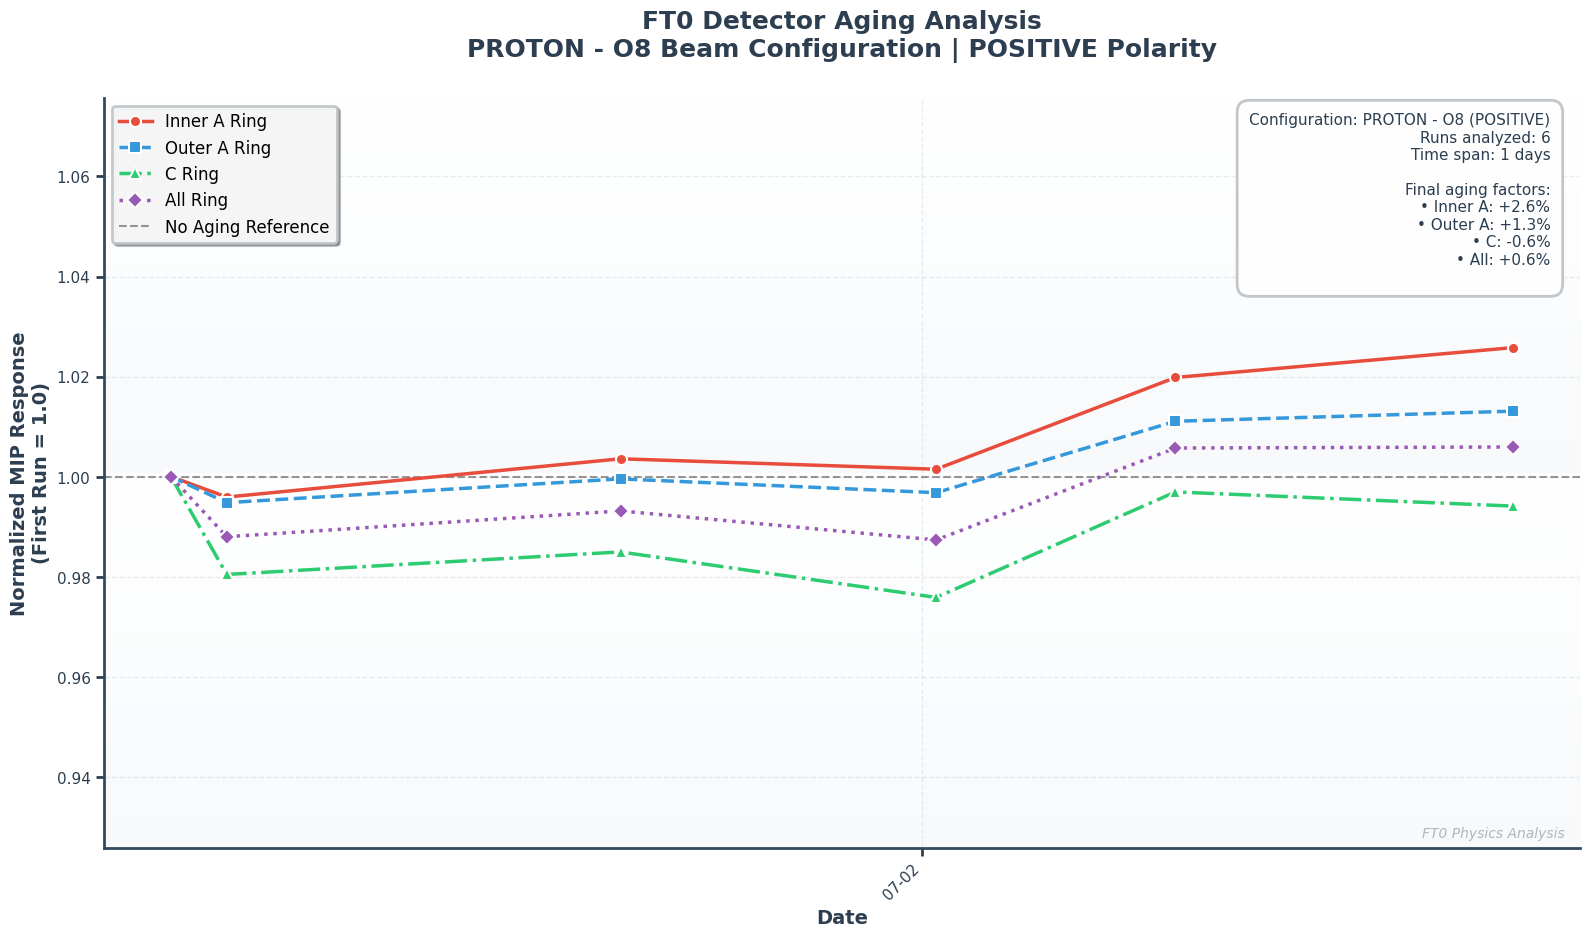

Creating plot for O8 - O8 (POSITIVE) (9 runs)
  Raw timestamps: [1751683109933, 1751695076850, 1751713818121]...
  Converted timestamps: 2025-07-05 04:38:29.933000 to 2025-07-07 10:19:55.389000
  Time span: 2 days
  Plot time range: 2025-07-05 04:38:29.933000 to 2025-07-07 10:19:55.389000
  Y-axis range: 0.930 to 1.080


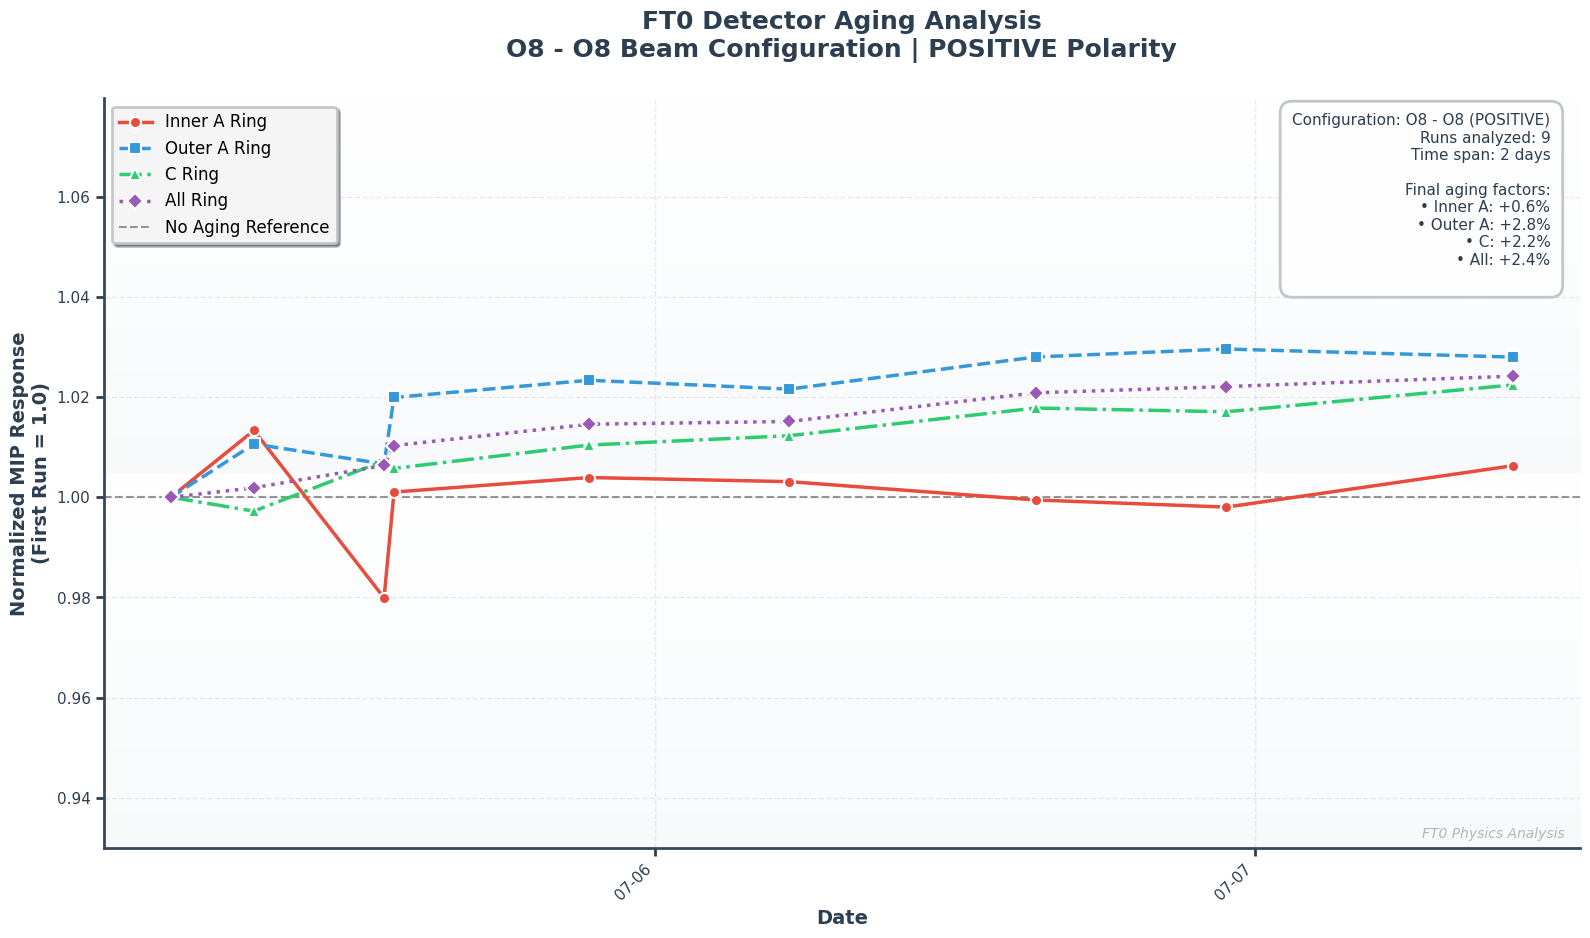

Creating plot for NE10 - NE10 (POSITIVE) (2 runs)
  Raw timestamps: [1751985015282, 1752012495222]...
  Converted timestamps: 2025-07-08 16:30:15.282000 to 2025-07-09 00:08:15.222000
  Time span: 0 days
  Plot time range: 2025-07-08 16:30:15.282000 to 2025-07-09 00:08:15.222000
  Y-axis range: 0.945 to 1.050


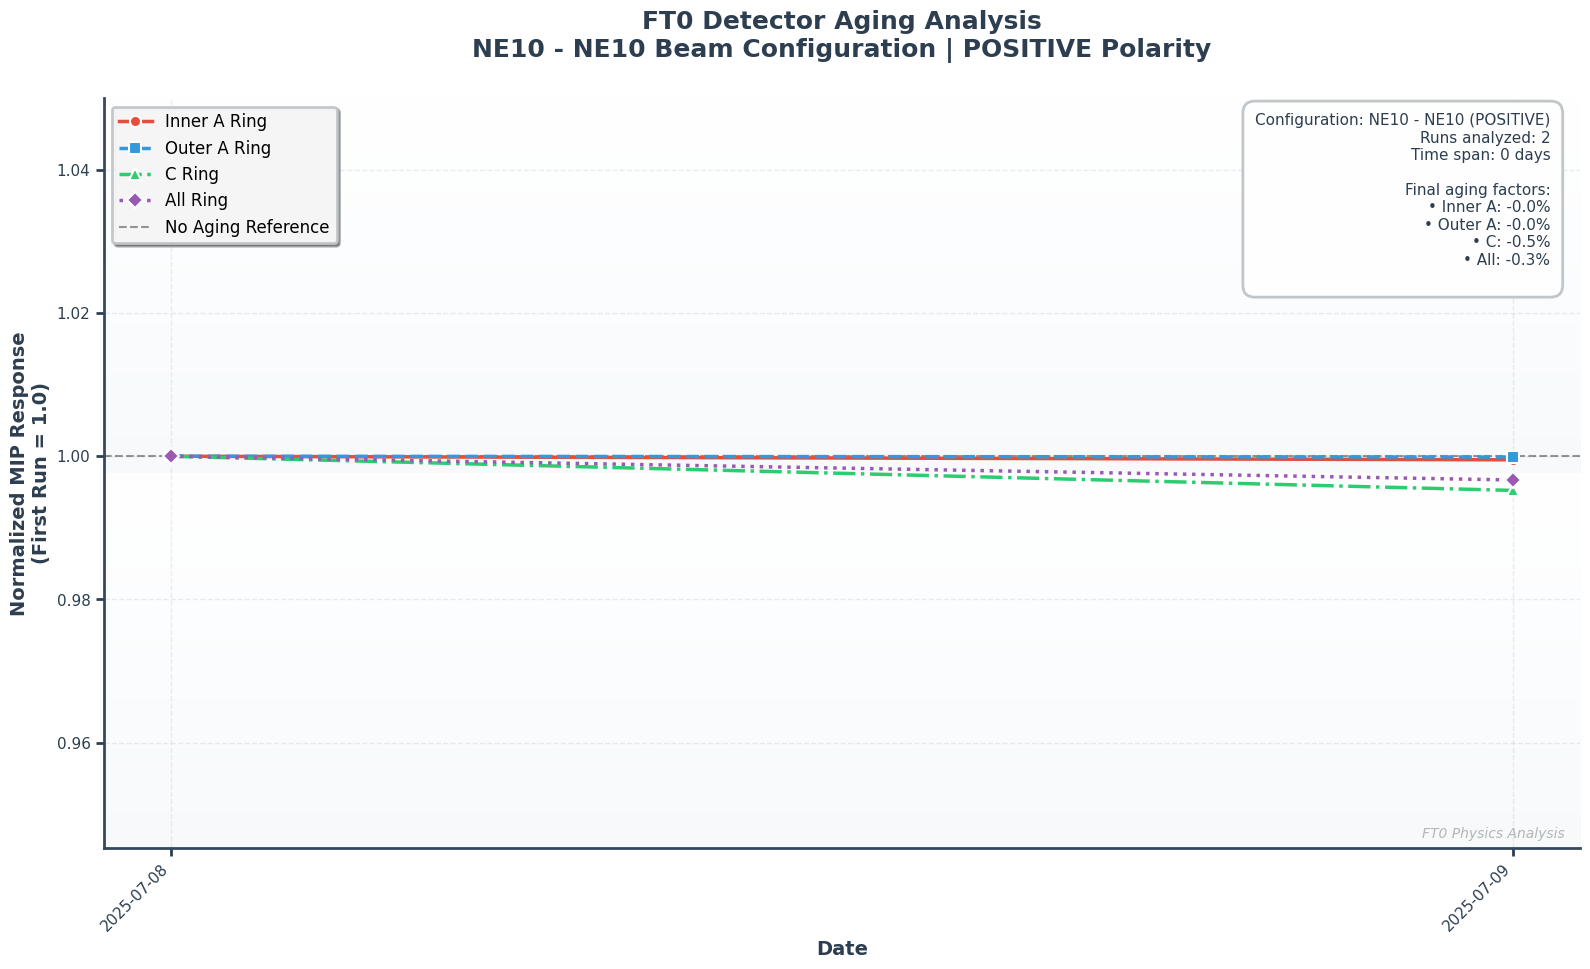


✨ Created 3 enhanced visualization plots!


In [80]:
def create_fancy_beam_plots(results):
    """
    Create beautiful, fancy plots for each beam type + polarity combination
    Each plot shows 4 lines: Inner A, Outer A, C, and All channels
    """
    
    if not results or len(results['run_numbers']) == 0:
        print("No results to visualize!")
        return []
    
    # Group data by beam configuration
    beam_data = {}
    for i, run in enumerate(results['run_numbers']):
        config = f"{results['beam_types'][i]} ({results['polarities'][i]})"
        
        if config not in beam_data:
            beam_data[config] = {
                'run_numbers': [],
                'timestamps': [],
                'Inner_A_mean': [],
                'Outer_A_mean': [],
                'C_mean': [],
                'All_mean': []
            }
        
        # Add data for this configuration
        beam_data[config]['run_numbers'].append(run)
        beam_data[config]['timestamps'].append(results['timestamps'][i])
        beam_data[config]['Inner_A_mean'].append(results['Inner_A_mean_gauss'][i])
        beam_data[config]['Outer_A_mean'].append(results['Outer_A_mean_gauss'][i])
        beam_data[config]['C_mean'].append(results['C_mean_gauss'][i])
        beam_data[config]['All_mean'].append(results['All_mean_gauss'][i])
    
    print(f"Creating fancy plots for {len(beam_data)} beam configurations...")
    
    # Enhanced styling parameters
    plt.style.use('default')  # Reset to clean style
    colors = {
        'Inner_A': '#E74C3C',    # Vibrant red
        'Outer_A': '#3498DB',    # Vibrant blue  
        'C': '#2ECC71',          # Vibrant green
        'All': '#9B59B6'         # Vibrant purple
    }
    
    line_styles = {
        'Inner_A': '-',          # Solid
        'Outer_A': '--',         # Dashed
        'C': '-.',               # Dash-dot
        'All': ':'               # Dotted
    }
    
    markers = {
        'Inner_A': 'o',          # Circle
        'Outer_A': 's',          # Square
        'C': '^',                # Triangle up
        'All': 'D'               # Diamond
    }
    
    figures = []
    
    for config, data in beam_data.items():
        if len(data['run_numbers']) < 2:
            print(f"Skipping {config}: insufficient data ({len(data['run_numbers'])} runs)")
            continue
            
        print(f"Creating plot for {config} ({len(data['run_numbers'])} runs)")
        
        # Debug timestamp conversion
        print(f"  Raw timestamps: {data['timestamps'][:3]}...")
        
        # Validate and convert timestamps with proper error handling
        timestamps = []
        valid_indices = []
        
        for i, ts in enumerate(data['timestamps']):
            try:
                # Convert from milliseconds to seconds, then to datetime
                if ts > 1e12:  # Timestamp in milliseconds
                    dt = datetime.fromtimestamp(ts / 1000.0)
                else:  # Timestamp in seconds
                    dt = datetime.fromtimestamp(ts)
                
                # Sanity check: ensure timestamp is reasonable (after 2020, before 2030)
                if dt.year >= 2020 and dt.year <= 2030:
                    timestamps.append(dt)
                    valid_indices.append(i)
                else:
                    print(f"  Warning: Invalid timestamp {ts} -> {dt}")
            except (ValueError, OSError) as e:
                print(f"  Warning: Could not convert timestamp {ts}: {e}")
                continue
        
        if len(timestamps) < 2:
            print(f"  Skipping {config}: insufficient valid timestamps")
            continue
        
        print(f"  Converted timestamps: {timestamps[0]} to {timestamps[-1]}")
        print(f"  Time span: {(timestamps[-1] - timestamps[0]).days} days")
        
        # Create figure with enhanced styling
        fig = plt.figure(figsize=(16, 10))
        fig.patch.set_facecolor('white')
        
        # Create main plot
        ax = plt.subplot(111)
        
        # Add subtle gradient background
        gradient = np.linspace(0, 1, 256).reshape(256, -1)
        gradient = np.vstack((gradient, gradient))
        ax.imshow(gradient, extent=[0, 1, 0, 1], transform=ax.transAxes, 
                 aspect='auto', alpha=0.03, cmap='Blues')
        
        # Plot each ring with enhanced styling
        ring_names = ['Inner_A', 'Outer_A', 'C', 'All']
        plot_data = {}
        all_times = []  # Collect all valid times for axis scaling
        
        for ring_name in ring_names:
            # Get data for valid timestamps only
            ring_means = []
            ring_times = []
            
            for i in valid_indices:
                mean_val = data[f'{ring_name}_mean'][i]
                if mean_val is not None:
                    ring_means.append(mean_val)
                    ring_times.append(timestamps[valid_indices.index(i)])
            
            if len(ring_means) < 2:
                print(f"  Skipping {ring_name}: insufficient valid data points")
                continue
            
            ring_means = np.array(ring_means, dtype=float)
            ring_times = np.array(ring_times)
            
            # Normalize to first run
            normalized_means = ring_means / ring_means[0]
            plot_data[ring_name] = (ring_times, normalized_means, ring_means)
            all_times.extend(ring_times)
            
            # Create the main line plot with clean styling (no glow effect)
            ax.plot(ring_times, normalized_means, 
                   color=colors[ring_name], 
                   linestyle=line_styles[ring_name],
                   marker=markers[ring_name],
                   markersize=8,
                   linewidth=2.5,  # Reduced from 3 for cleaner lines
                   markeredgewidth=1.5,
                   markeredgecolor='white',
                   alpha=1.0,  # Full opacity for crisp lines
                   label=f'{ring_name.replace("_", " ")} Ring',
                   zorder=5,
                   antialiased=True)  # Ensure anti-aliasing
        
        if not plot_data:
            print(f"  No valid data to plot for {config}")
            plt.close(fig)
            continue
        
        # Set proper x-axis limits based on actual data
        if all_times:
            time_min = min(all_times)
            time_max = max(all_times)
            time_range = time_max - time_min
            
            # Add 5% padding on each side
            padding_seconds = time_range.total_seconds() / 20  # 5% of range in seconds
            ax.set_xlim(time_min - timedelta(seconds=padding_seconds), 
                       time_max + timedelta(seconds=padding_seconds))
            
            print(f"  Plot time range: {time_min} to {time_max}")
        
        # Auto-scale Y-axis based on actual data with padding
        if plot_data:
            all_y_values = []
            for ring_name, (times, normalized, raw) in plot_data.items():
                all_y_values.extend(normalized)
            
            if all_y_values:
                y_min = min(all_y_values)
                y_max = max(all_y_values)
                y_range = y_max - y_min
                
                # Add 10% padding on each side, but ensure we show meaningful range
                if y_range < 0.1:  # If range is very small, use fixed padding
                    y_padding = 0.05
                else:
                    y_padding = y_range * 0.1
                
                ax.set_ylim(y_min - y_padding, y_max + y_padding)
                print(f"  Y-axis range: {y_min - y_padding:.3f} to {y_max + y_padding:.3f}")
        
        # Add reference line at y=1 with dashed style and lower alpha
        ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.4, linewidth=1.5, 
                  label='No Aging Reference', zorder=2)
        
        # Enhanced plot styling
        ax.set_ylabel('Normalized MIP Response\n(First Run = 1.0)', 
                     fontweight='bold', fontsize=14, color='#2C3E50')
        ax.set_xlabel('Date', fontweight='bold', fontsize=14, color='#2C3E50')
        
        # Create sophisticated title
        beam_type = config.split(' (')[0]
        polarity = config.split(' (')[1].replace(')', '')
        title = f'FT0 Detector Aging Analysis\n{beam_type} Beam Configuration | {polarity} Polarity'
        ax.set_title(title, fontsize=18, fontweight='bold', color='#2C3E50', pad=30)
        
        # Enhanced legend with custom styling - UPPER LEFT
        legend = ax.legend(loc='upper left', fontsize=12, frameon=True, 
                          fancybox=True, shadow=True, framealpha=0.9,
                          edgecolor='#BDC3C7', facecolor='white')
        legend.get_frame().set_linewidth(2)
        
        # Enhanced grid
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=1, color='#BDC3C7')
        ax.set_axisbelow(True)
        
        # Sophisticated axis styling
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#34495E')
        ax.spines['bottom'].set_color('#34495E')
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        
        # Enhanced tick styling with smart date spacing to avoid overlap
        ax.tick_params(axis='both', which='major', labelsize=11, colors='#2C3E50',
                      width=2, length=6)
        
        # Smart X-axis formatting to avoid date overlap
        if all_times:
            unique_times = sorted(list(set(all_times)))
            
            # Use automatic date locator to avoid overlap
            if len(unique_times) <= 5:
                # Few points - show all dates
                ax.set_xticks(unique_times)
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            elif len(unique_times) <= 10:
                # Medium number - show every other date or use auto locator
                ax.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(unique_times)//5)))
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            else:
                # Many points - let matplotlib handle it automatically
                ax.xaxis.set_major_locator(mdates.AutoDateLocator())
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            
            # Rotate labels and adjust spacing
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            
            # Add minor grid for better readability if many points
            if len(unique_times) > 5:
                ax.xaxis.set_minor_locator(mdates.DayLocator())
                ax.grid(True, which='minor', alpha=0.1, linestyle=':', linewidth=0.5)
        
        # Add statistics box with enhanced styling - UPPER RIGHT
        if plot_data:
            actual_time_span = (max(all_times) - min(all_times)).days
            stats_text = f"Configuration: {config}\n"
            stats_text += f"Runs analyzed: {len(set(valid_indices))}\n"
            stats_text += f"Time span: {actual_time_span} days\n\n"
            stats_text += "Final aging factors:\n"
            
            for ring_name in ring_names:
                if ring_name in plot_data:
                    final_factor = plot_data[ring_name][1][-1]
                    change_pct = (final_factor - 1.0) * 100
                    stats_text += f"• {ring_name.replace('_', ' ')}: {change_pct:+.1f}%\n"
            
            # Position stats box in UPPER RIGHT to avoid legend overlap
            ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=11,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round,pad=0.8', facecolor='white', 
                           edgecolor='#BDC3C7', alpha=0.95, linewidth=2),
                   color='#2C3E50', fontweight='normal')
        
        # Add watermark/subtitle
        ax.text(0.99, 0.01, 'FT0 Physics Analysis', transform=ax.transAxes,
               fontsize=10, alpha=0.6, ha='right', va='bottom',
               style='italic', color='#7F8C8D')
        
        # Enhanced layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.9, bottom=0.15)
        
        figures.append(fig)
        
        # Display the plot
        plt.show()
    
    print(f"\n✨ Created {len(figures)} enhanced visualization plots!")
    return figures

# Create the enhanced visualizations
if 'results' in locals():
    fancy_figures = create_fancy_beam_plots(results)
else:
    print("❌ Please run the main analysis first to generate 'results' variable")

Creating fancy plots for 3 beam configurations...
Creating plot for PROTON - O8 (POSITIVE) (6 runs)
  Raw timestamps: [1751341777720, 1751346650887, 1751380945841]...
  Converted timestamps: 2025-07-01 05:49:37.720000 to 2025-07-02 14:17:55.792000
  Time span: 1 days
  Plot time range: 2025-07-01 05:49:37.720000 to 2025-07-02 14:17:55.792000
  Y-axis range: 0.926 to 1.076


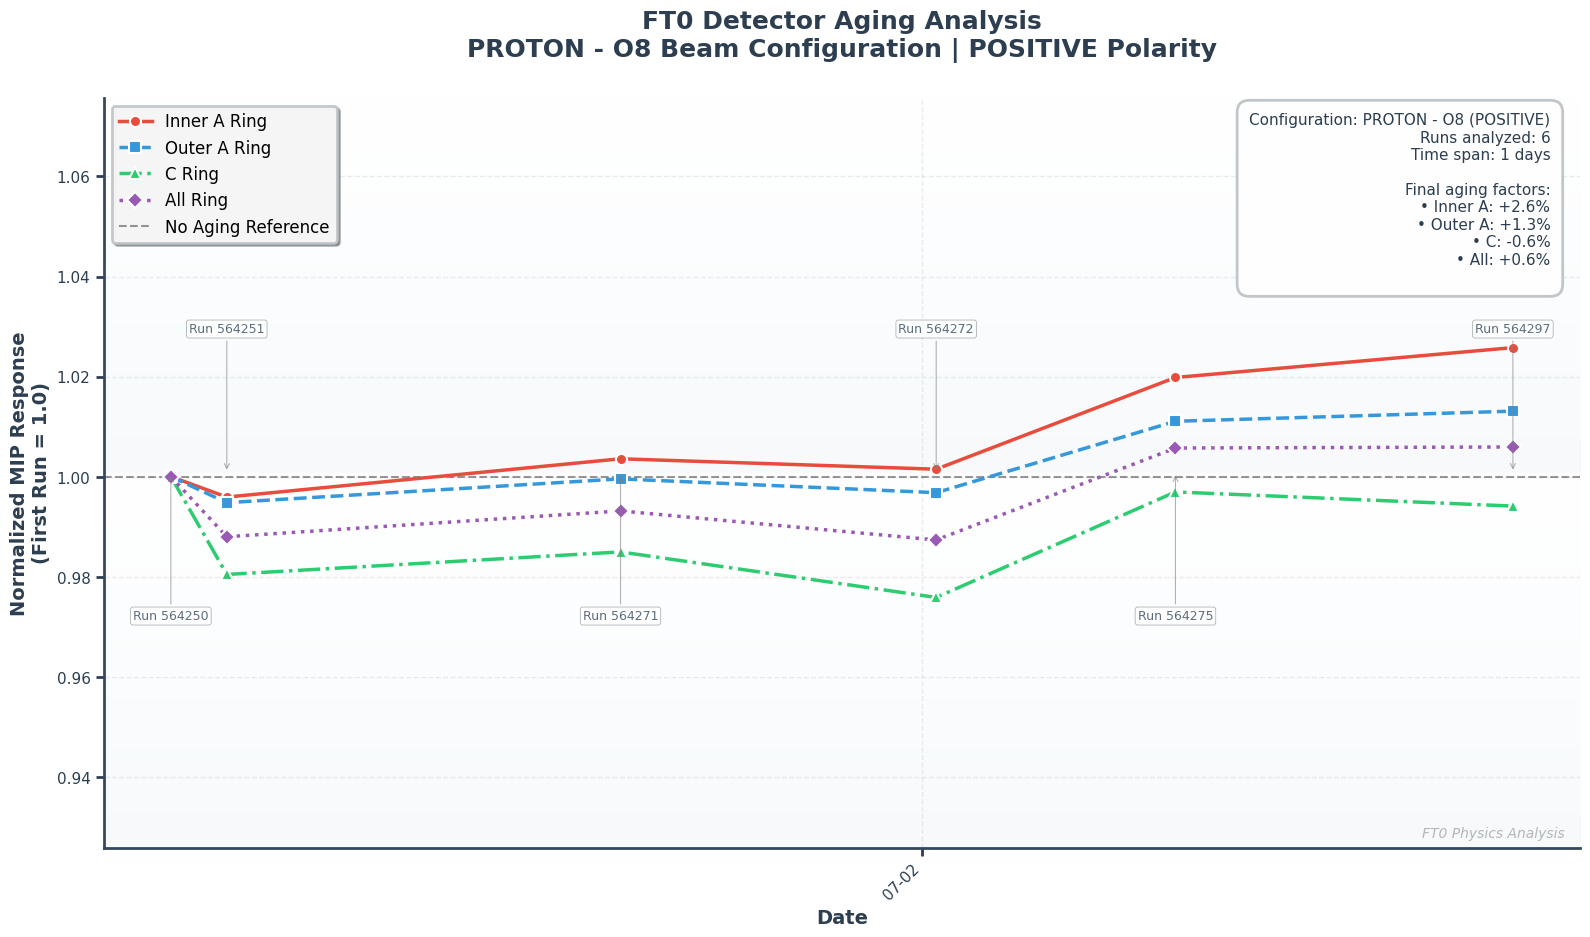

Creating plot for O8 - O8 (POSITIVE) (9 runs)
  Raw timestamps: [1751683109933, 1751695076850, 1751713818121]...
  Converted timestamps: 2025-07-05 04:38:29.933000 to 2025-07-07 10:19:55.389000
  Time span: 2 days
  Plot time range: 2025-07-05 04:38:29.933000 to 2025-07-07 10:19:55.389000
  Y-axis range: 0.930 to 1.080


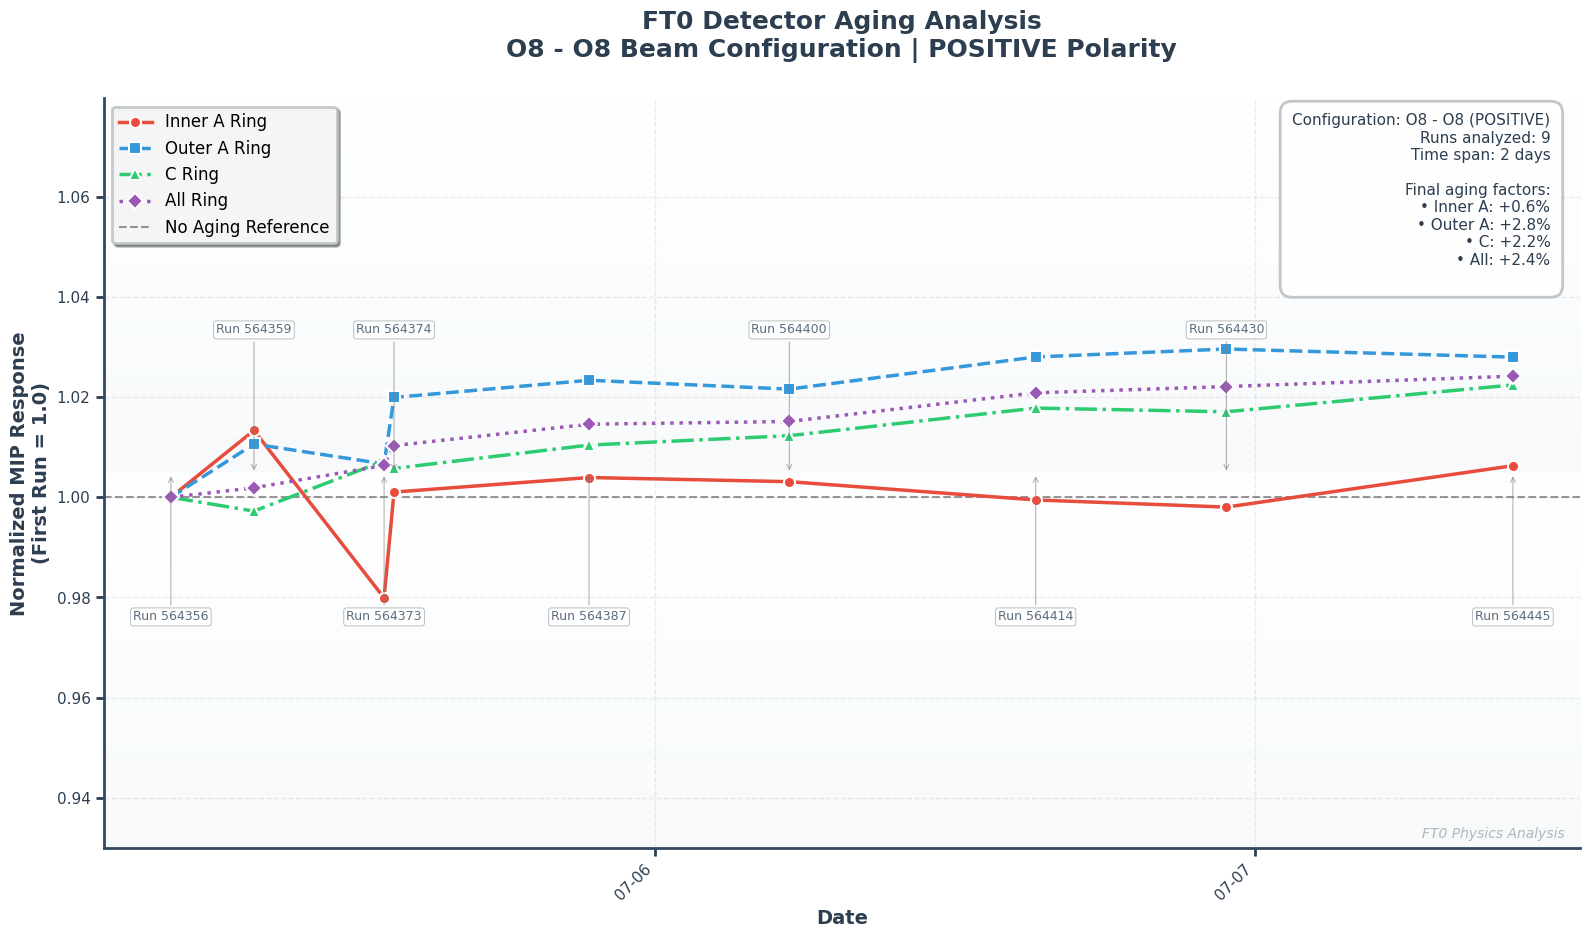

Creating plot for NE10 - NE10 (POSITIVE) (2 runs)
  Raw timestamps: [1751985015282, 1752012495222]...
  Converted timestamps: 2025-07-08 16:30:15.282000 to 2025-07-09 00:08:15.222000
  Time span: 0 days
  Plot time range: 2025-07-08 16:30:15.282000 to 2025-07-09 00:08:15.222000
  Y-axis range: 0.945 to 1.050


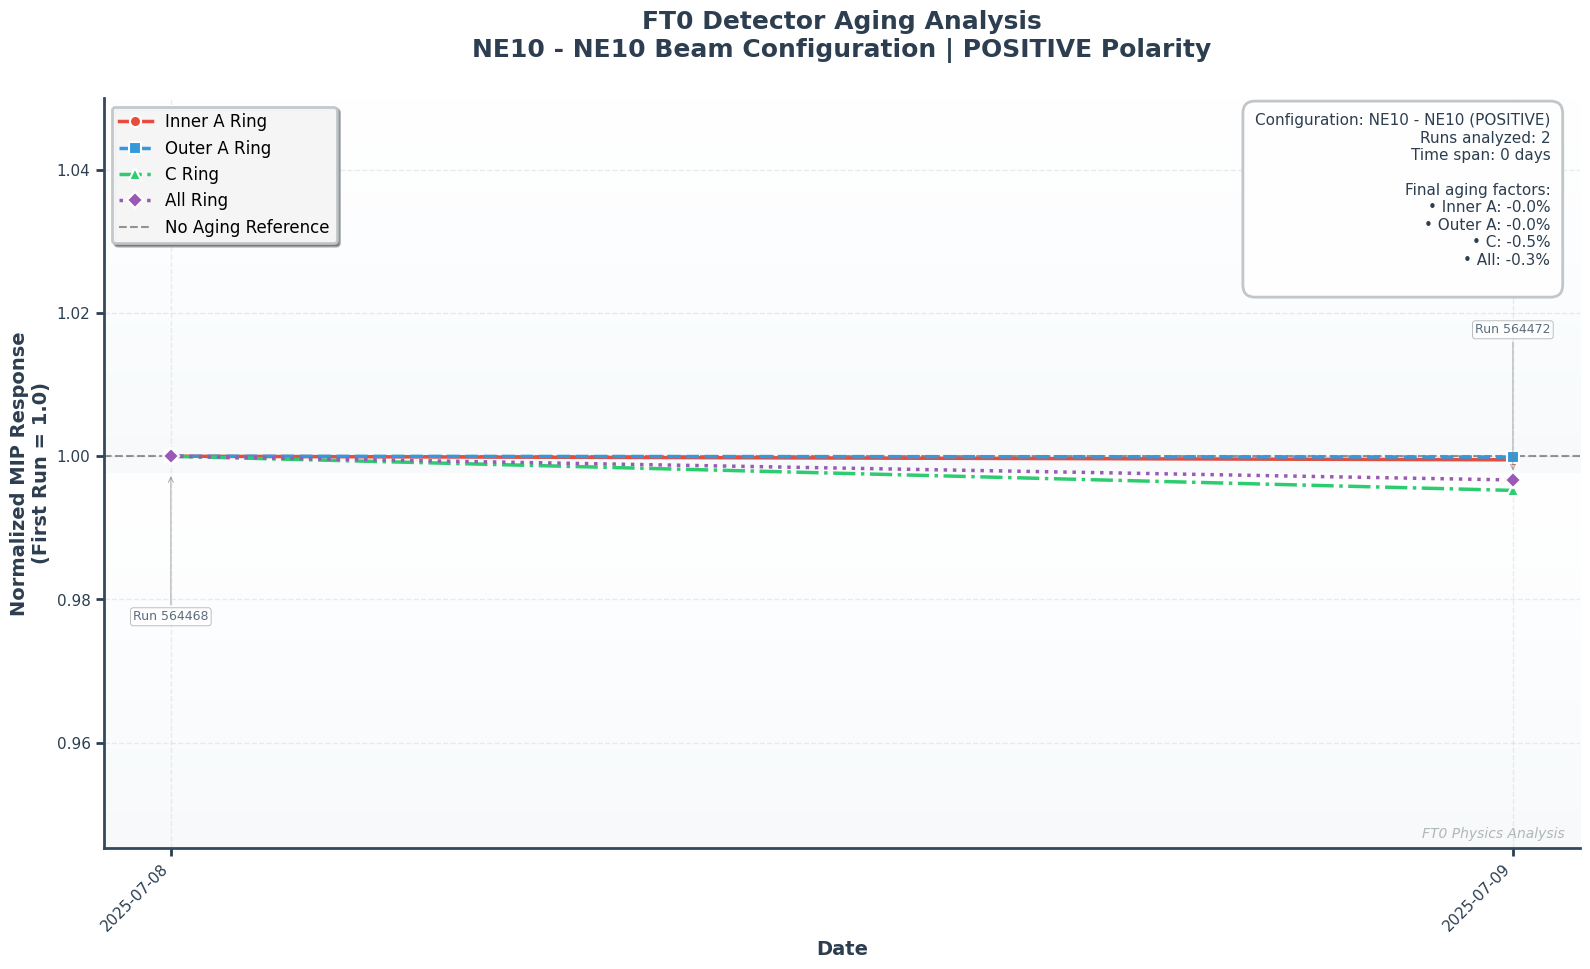


✨ Created 3 enhanced visualization plots!


In [84]:
def create_fancy_beam_plots(results):
    """
    Create beautiful, fancy plots for each beam type + polarity combination
    Each plot shows 4 lines: Inner A, Outer A, C, and All channels
    """
    
    if not results or len(results['run_numbers']) == 0:
        print("No results to visualize!")
        return []
    
    # Group data by beam configuration
    beam_data = {}
    for i, run in enumerate(results['run_numbers']):
        config = f"{results['beam_types'][i]} ({results['polarities'][i]})"
        
        if config not in beam_data:
            beam_data[config] = {
                'run_numbers': [],
                'timestamps': [],
                'Inner_A_mean': [],
                'Outer_A_mean': [],
                'C_mean': [],
                'All_mean': []
            }
        
        # Add data for this configuration
        beam_data[config]['run_numbers'].append(run)
        beam_data[config]['timestamps'].append(results['timestamps'][i])
        beam_data[config]['Inner_A_mean'].append(results['Inner_A_mean_gauss'][i])  # Using Gaussian results
        beam_data[config]['Outer_A_mean'].append(results['Outer_A_mean_gauss'][i])
        beam_data[config]['C_mean'].append(results['C_mean_gauss'][i])
        beam_data[config]['All_mean'].append(results['All_mean_gauss'][i])
    
    print(f"Creating fancy plots for {len(beam_data)} beam configurations...")
    
    # Enhanced styling parameters
    plt.style.use('default')  # Reset to clean style
    colors = {
        'Inner_A': '#E74C3C',    # Vibrant red
        'Outer_A': '#3498DB',    # Vibrant blue  
        'C': '#2ECC71',          # Vibrant green
        'All': '#9B59B6'         # Vibrant purple
    }
    
    line_styles = {
        'Inner_A': '-',          # Solid
        'Outer_A': '--',         # Dashed
        'C': '-.',               # Dash-dot
        'All': ':'               # Dotted
    }
    
    markers = {
        'Inner_A': 'o',          # Circle
        'Outer_A': 's',          # Square
        'C': '^',                # Triangle up
        'All': 'D'               # Diamond
    }
    
    figures = []
    
    for config, data in beam_data.items():
        if len(data['run_numbers']) < 2:
            print(f"Skipping {config}: insufficient data ({len(data['run_numbers'])} runs)")
            continue
            
        print(f"Creating plot for {config} ({len(data['run_numbers'])} runs)")
        
        # Debug timestamp conversion
        print(f"  Raw timestamps: {data['timestamps'][:3]}...")
        
        # Validate and convert timestamps with proper error handling
        timestamps = []
        valid_indices = []
        valid_run_numbers = []
        
        for i, ts in enumerate(data['timestamps']):
            try:
                # Convert from milliseconds to seconds, then to datetime
                if ts > 1e12:  # Timestamp in milliseconds
                    dt = datetime.fromtimestamp(ts / 1000.0)
                else:  # Timestamp in seconds
                    dt = datetime.fromtimestamp(ts)
                
                # Sanity check: ensure timestamp is reasonable (after 2020, before 2030)
                if dt.year >= 2020 and dt.year <= 2030:
                    timestamps.append(dt)
                    valid_indices.append(i)
                    valid_run_numbers.append(data['run_numbers'][i])
                else:
                    print(f"  Warning: Invalid timestamp {ts} -> {dt}")
            except (ValueError, OSError) as e:
                print(f"  Warning: Could not convert timestamp {ts}: {e}")
                continue
        
        if len(timestamps) < 2:
            print(f"  Skipping {config}: insufficient valid timestamps")
            continue
        
        print(f"  Converted timestamps: {timestamps[0]} to {timestamps[-1]}")
        print(f"  Time span: {(timestamps[-1] - timestamps[0]).days} days")
        
        # Create figure with enhanced styling
        fig = plt.figure(figsize=(16, 10))
        fig.patch.set_facecolor('white')
        
        # Create main plot
        ax = plt.subplot(111)
        
        # Add subtle gradient background
        gradient = np.linspace(0, 1, 256).reshape(256, -1)
        gradient = np.vstack((gradient, gradient))
        ax.imshow(gradient, extent=[0, 1, 0, 1], transform=ax.transAxes, 
                 aspect='auto', alpha=0.03, cmap='Blues')
        
        # Plot each ring with enhanced styling
        ring_names = ['Inner_A', 'Outer_A', 'C', 'All']
        plot_data = {}
        all_times = []  # Collect all valid times for axis scaling
        all_run_numbers = []  # Collect all run numbers for axis labeling
        
        for ring_name in ring_names:
            # Get data for valid timestamps only
            ring_means = []
            ring_times = []
            ring_runs = []
            
            for i in valid_indices:
                mean_val = data[f'{ring_name}_mean'][i]
                if mean_val is not None:
                    ring_means.append(mean_val)
                    ring_times.append(timestamps[valid_indices.index(i)])
                    ring_runs.append(valid_run_numbers[valid_indices.index(i)])
            
            if len(ring_means) < 2:
                print(f"  Skipping {ring_name}: insufficient valid data points")
                continue
            
            ring_means = np.array(ring_means, dtype=float)
            ring_times = np.array(ring_times)
            ring_runs = np.array(ring_runs)
            
            # Normalize to first run
            normalized_means = ring_means / ring_means[0]
            plot_data[ring_name] = (ring_times, normalized_means, ring_means, ring_runs)
            all_times.extend(ring_times)
            all_run_numbers.extend(ring_runs)
            
            # Create the main line plot with clean styling (no glow effect)
            ax.plot(ring_times, normalized_means, 
                   color=colors[ring_name], 
                   linestyle=line_styles[ring_name],
                   marker=markers[ring_name],
                   markersize=8,
                   linewidth=2.5,  # Reduced from 3 for cleaner lines
                   markeredgewidth=1.5,
                   markeredgecolor='white',
                   alpha=1.0,  # Full opacity for crisp lines
                   label=f'{ring_name.replace("_", " ")} Ring',
                   zorder=5,
                   antialiased=True)  # Ensure anti-aliasing
        
        if not plot_data:
            print(f"  No valid data to plot for {config}")
            plt.close(fig)
            continue
        
        # Set proper x-axis limits based on actual data
        if all_times:
            time_min = min(all_times)
            time_max = max(all_times)
            time_range = time_max - time_min
            
            # Add 5% padding on each side
            padding_seconds = time_range.total_seconds() / 20  # 5% of range in seconds
            ax.set_xlim(time_min - timedelta(seconds=padding_seconds), 
                       time_max + timedelta(seconds=padding_seconds))
            
            print(f"  Plot time range: {time_min} to {time_max}")
        
        # Auto-scale Y-axis based on actual data with padding
        if plot_data:
            all_y_values = []
            for ring_name, (times, normalized, raw, runs) in plot_data.items():
                all_y_values.extend(normalized)
            
            if all_y_values:
                y_min = min(all_y_values)
                y_max = max(all_y_values)
                y_range = y_max - y_min
                
                # Add 10% padding on each side, but ensure we show meaningful range
                if y_range < 0.1:  # If range is very small, use fixed padding
                    y_padding = 0.05
                else:
                    y_padding = y_range * 0.1
                
                ax.set_ylim(y_min - y_padding, y_max + y_padding)
                print(f"  Y-axis range: {y_min - y_padding:.3f} to {y_max + y_padding:.3f}")
        
        # Add reference line at y=1 with dashed style and lower alpha
        ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.4, linewidth=1.5, 
                  label='No Aging Reference', zorder=2)
        
        # Enhanced plot styling
        ax.set_ylabel('Normalized MIP Response\n(First Run = 1.0)', 
                     fontweight='bold', fontsize=14, color='#2C3E50')
        ax.set_xlabel('Date', fontweight='bold', fontsize=14, color='#2C3E50')
        
        # Create sophisticated title
        beam_type = config.split(' (')[0]
        polarity = config.split(' (')[1].replace(')', '')
        title = f'FT0 Detector Aging Analysis\n{beam_type} Beam Configuration | {polarity} Polarity'
        ax.set_title(title, fontsize=18, fontweight='bold', color='#2C3E50', pad=30)
        
        # Enhanced legend with custom styling - UPPER LEFT
        legend = ax.legend(loc='upper left', fontsize=12, frameon=True, 
                          fancybox=True, shadow=True, framealpha=0.9,
                          edgecolor='#BDC3C7', facecolor='white')
        legend.get_frame().set_linewidth(2)
        
        # Enhanced grid
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=1, color='#BDC3C7')
        ax.set_axisbelow(True)
        
        # Sophisticated axis styling
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#34495E')
        ax.spines['bottom'].set_color('#34495E')
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        
        # Enhanced tick styling with smart date spacing to avoid overlap
        ax.tick_params(axis='both', which='major', labelsize=11, colors='#2C3E50',
                      width=2, length=6)
        
        # Smart X-axis formatting to avoid date overlap
        if all_times:
            unique_times = sorted(list(set(all_times)))
            
            # Use automatic date locator to avoid overlap
            if len(unique_times) <= 5:
                # Few points - show all dates
                ax.set_xticks(unique_times)
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            elif len(unique_times) <= 10:
                # Medium number - show every other date or use auto locator
                ax.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(unique_times)//5)))
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            else:
                # Many points - let matplotlib handle it automatically
                ax.xaxis.set_major_locator(mdates.AutoDateLocator())
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            
            # Rotate labels and adjust spacing
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            
            # Add minor grid for better readability if many points
            if len(unique_times) > 5:
                ax.xaxis.set_minor_locator(mdates.DayLocator())
                ax.grid(True, which='minor', alpha=0.1, linestyle=':', linewidth=0.5)
        
        # ADD RUN NUMBERS: Create smart run number annotations
        if all_times and all_run_numbers:
            # Get unique time-run pairs and sort by time
            unique_time_runs = []
            seen_times = set()
            for time, run in zip(all_times, all_run_numbers):
                time_key = time.strftime('%Y-%m-%d %H:%M')  # Round to minute precision
                if time_key not in seen_times:
                    unique_time_runs.append((time, run))
                    seen_times.add(time_key)
            
            unique_time_runs.sort(key=lambda x: x[0])  # Sort by time
            
            # Add run number annotations with smart positioning
            y_limits = ax.get_ylim()
            y_range = y_limits[1] - y_limits[0]
            
            for i, (time, run) in enumerate(unique_time_runs):
                # Alternate positions above and below to avoid overlap
                if i % 2 != 0:
                    # Position above
                    y_pos = y_limits[1] - y_range * 0.30
                    va = 'top'
                    arrow_props = dict(arrowstyle='->', color='gray', alpha=0.6, lw=0.8)
                else:
                    # Position below  
                    y_pos = y_limits[0] + y_range * 0.30
                    va = 'bottom'
                    arrow_props = dict(arrowstyle='->', color='gray', alpha=0.6, lw=0.8)
                
                # Add annotation with arrow pointing to x-axis
                ax.annotate(f'Run {run}', 
                           xy=(time, (y_limits[0] + y_limits[1]) / 2), 
                           xytext=(time, y_pos),
                           ha='center', va=va,
                           fontsize=9, color='#34495E', alpha=0.8,
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', 
                                   edgecolor='gray', alpha=0.7, linewidth=0.5),
                           arrowprops=arrow_props,
                           zorder=10)
        
        # Add statistics box with enhanced styling - UPPER RIGHT
        if plot_data:
            actual_time_span = (max(all_times) - min(all_times)).days
            stats_text = f"Configuration: {config}\n"
            stats_text += f"Runs analyzed: {len(set(all_run_numbers))}\n"
            stats_text += f"Time span: {actual_time_span} days\n\n"
            stats_text += "Final aging factors:\n"
            
            for ring_name in ring_names:
                if ring_name in plot_data:
                    final_factor = plot_data[ring_name][1][-1]
                    change_pct = (final_factor - 1.0) * 100
                    stats_text += f"• {ring_name.replace('_', ' ')}: {change_pct:+.1f}%\n"
            
            # Position stats box in UPPER RIGHT to avoid legend overlap
            ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=11,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round,pad=0.8', facecolor='white', 
                           edgecolor='#BDC3C7', alpha=0.95, linewidth=2),
                   color='#2C3E50', fontweight='normal')
        
        # Add watermark/subtitle
        ax.text(0.99, 0.01, 'FT0 Physics Analysis', transform=ax.transAxes,
               fontsize=10, alpha=0.6, ha='right', va='bottom',
               style='italic', color='#7F8C8D')
        
        # Enhanced layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.9, bottom=0.15)
        
        figures.append(fig)
        
        # Display the plot
        plt.show()
    
    print(f"\n✨ Created {len(figures)} enhanced visualization plots!")
    return figures

# Create the enhanced visualizations
if 'results' in locals():
    fancy_figures = create_fancy_beam_plots(results)
else:
    print("❌ Please run the main analysis first to generate 'results' variable")

## Weighted vs Gaussian mean comparison


🔬 FT0 DETECTOR AGING ANALYSIS - METHOD COMPARISON

METHOD COMPARISON SUMMARY TABLE
Ring         Gauss    Weighted Both     Mean Diff    Std Diff     Max Diff    
--------------------------------------------------------------------------------
Inner A      17       17       17       -0.3235      0.8663       1.5467      
Outer A      17       17       17       -0.1901      0.3377       0.6743      
C            17       17       17       -0.0305      0.3154       0.5096      
All          17       17       17       -0.2090      0.3428       0.6255      
--------------------------------------------------------------------------------
Legend:
  Gauss/Weighted: Number of successful fits
  Both: Number of runs where both methods succeeded
  Mean/Std/Max Diff: Statistics of (Gaussian - Weighted Average) differences

📊 Creating method comparison plots...
Creating comparison plots for 3 beam configurations...
Creating comparison plot for PROTON - O8 (POSITIVE) (6 runs)


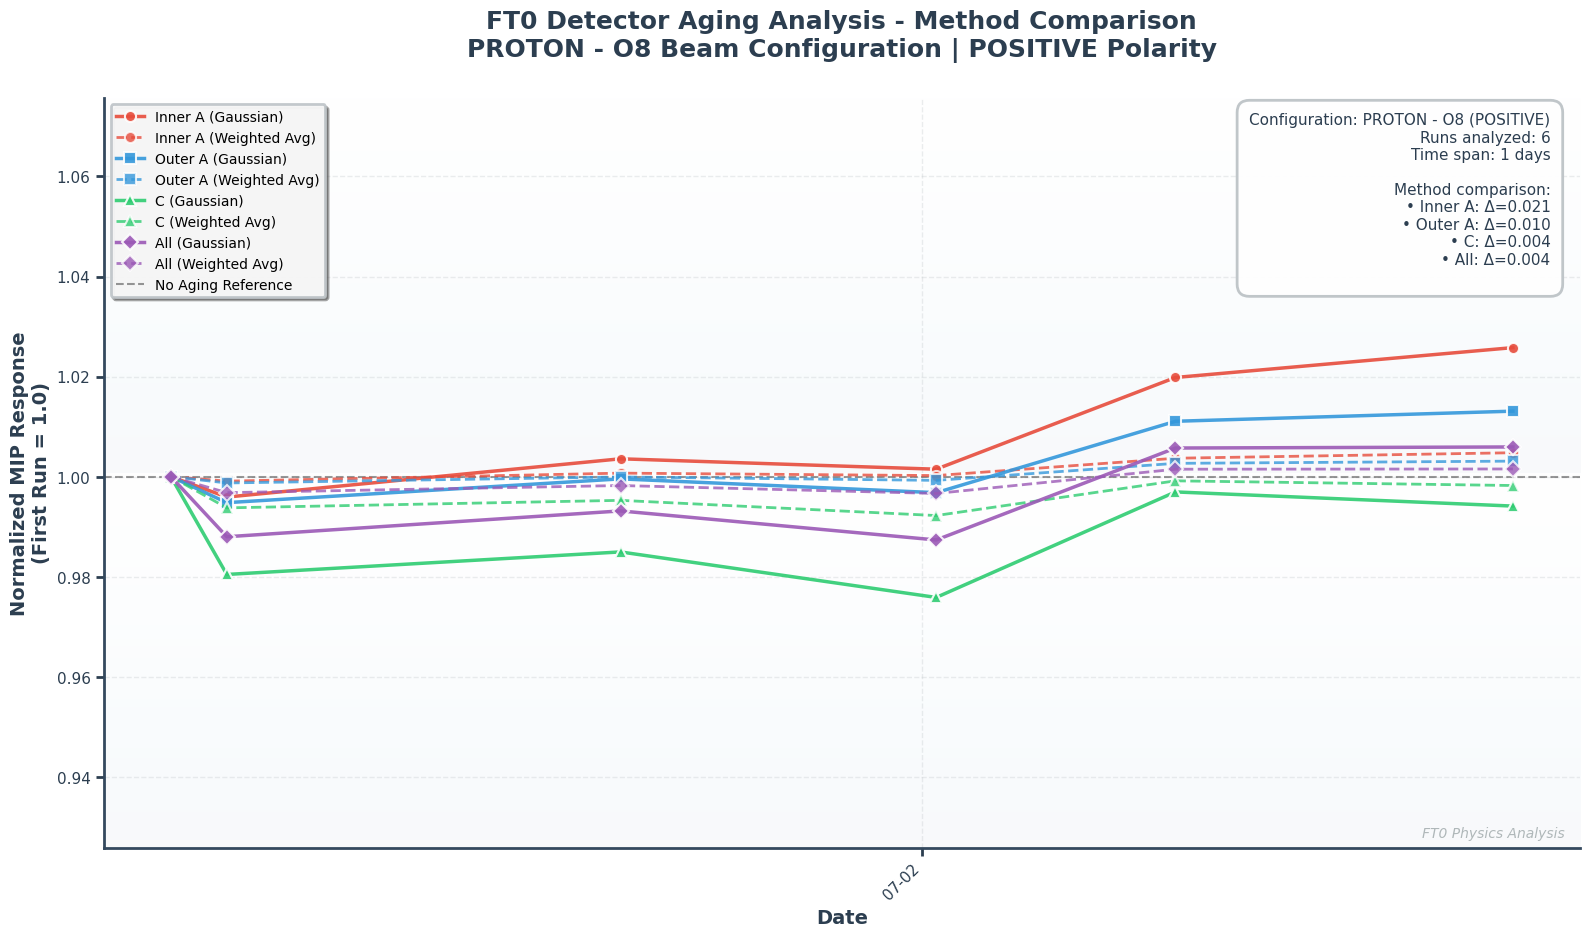

Creating comparison plot for O8 - O8 (POSITIVE) (9 runs)


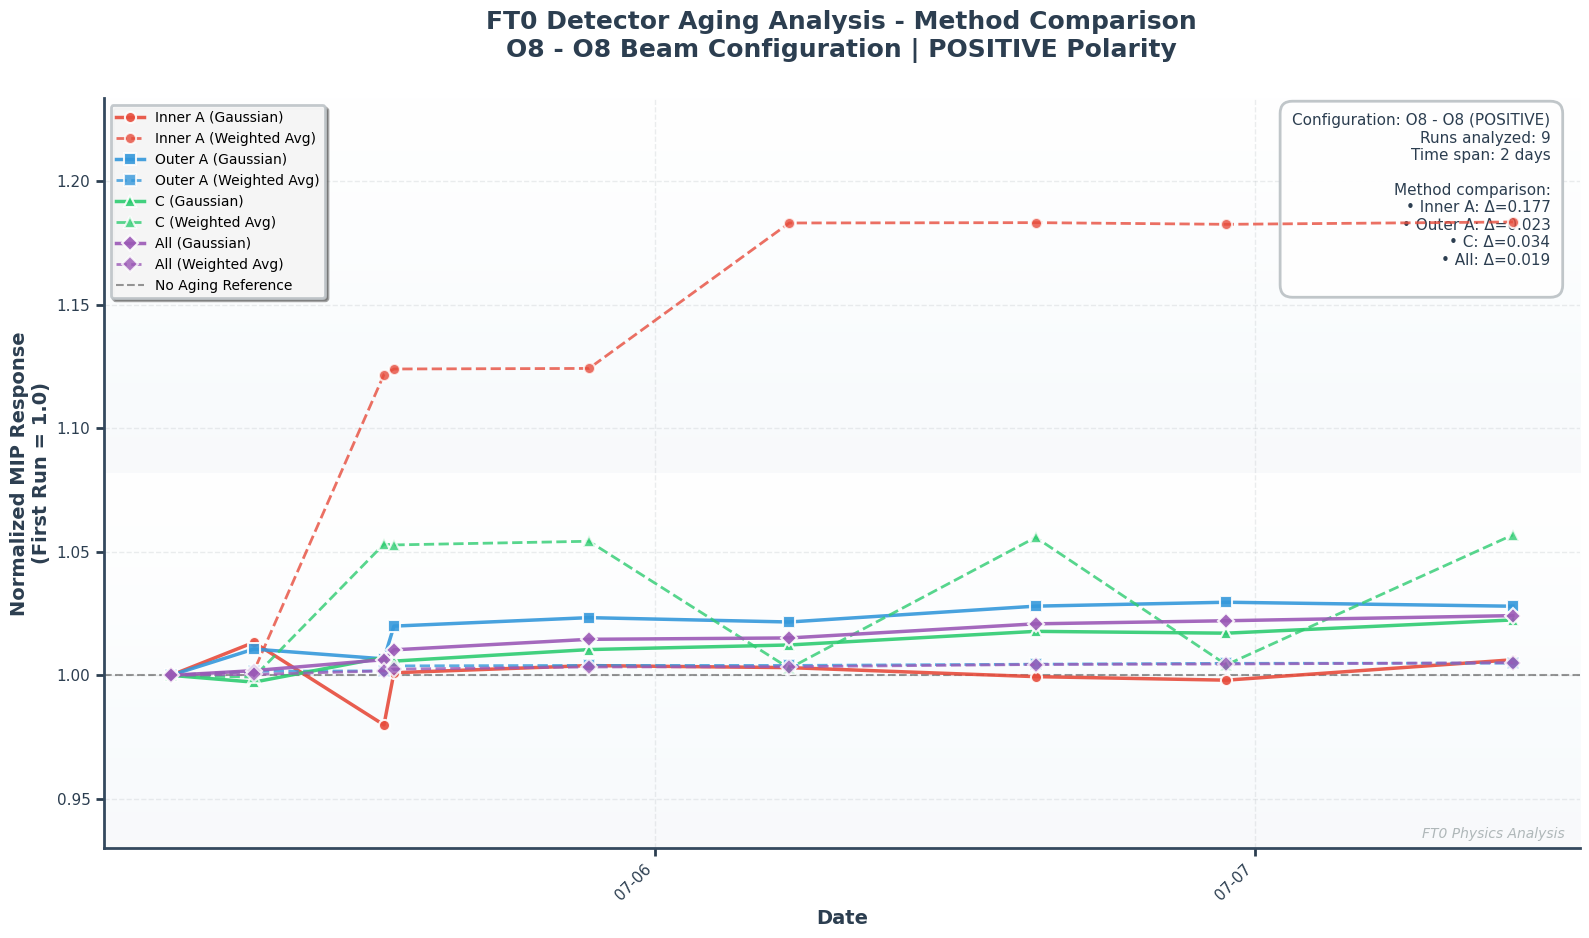

Creating comparison plot for NE10 - NE10 (POSITIVE) (2 runs)


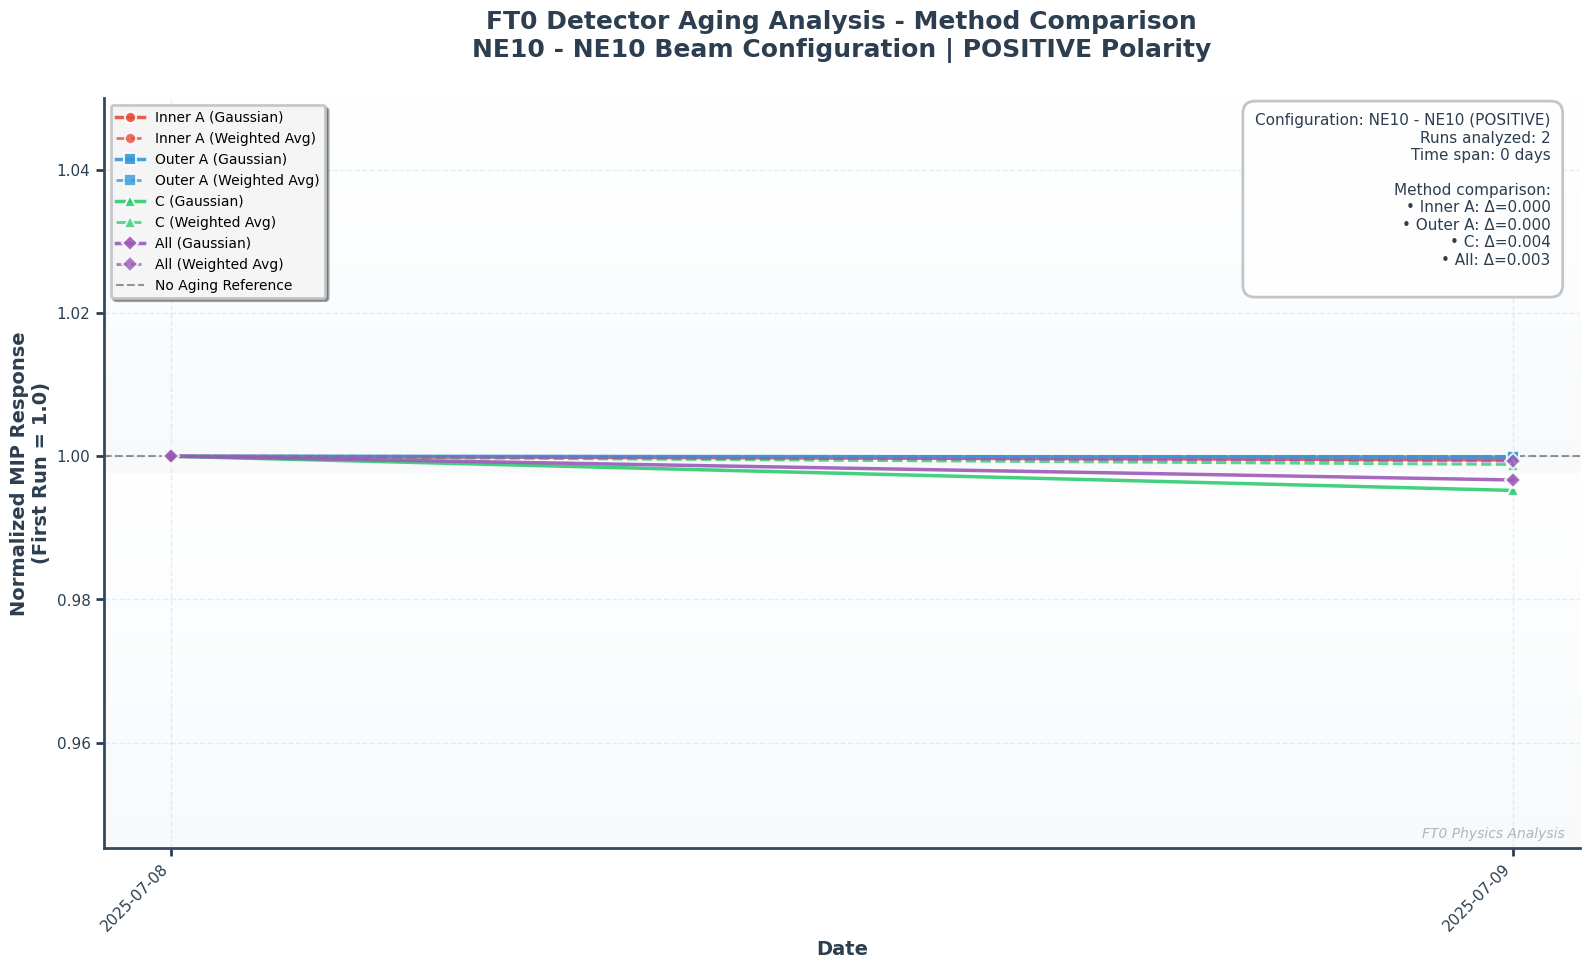


✨ Created 3 method comparison plots!

💡 Available plotting functions:
  plot_gaussian_only(results)     - Show only Gaussian fits
  plot_weighted_only(results)     - Show only weighted averages
  plot_both_methods(results)      - Show both methods for comparison
  create_method_summary_table(results) - Print comparison statistics


In [67]:
def create_fancy_beam_plots_comparison(results, method='both'):
    """
    Create beautiful plots comparing Gaussian vs Weighted Average methods
    
    Args:
        results: Results dictionary from processing
        method: 'gauss', 'weighted', or 'both' to show comparison
    """
    
    if not results or len(results['run_numbers']) == 0:
        print("No results to visualize!")
        return []
    
    # Group data by beam configuration
    beam_data = {}
    for i, run in enumerate(results['run_numbers']):
        config = f"{results['beam_types'][i]} ({results['polarities'][i]})"
        
        if config not in beam_data:
            beam_data[config] = {
                'run_numbers': [],
                'timestamps': [],
                'Inner_A_mean_gauss': [], 'Inner_A_mean_weighted': [],
                'Outer_A_mean_gauss': [], 'Outer_A_mean_weighted': [],
                'C_mean_gauss': [], 'C_mean_weighted': [],
                'All_mean_gauss': [], 'All_mean_weighted': []
            }
        
        # Add data for this configuration
        beam_data[config]['run_numbers'].append(run)
        beam_data[config]['timestamps'].append(results['timestamps'][i])
        beam_data[config]['Inner_A_mean_gauss'].append(results['Inner_A_mean_gauss'][i])
        beam_data[config]['Inner_A_mean_weighted'].append(results['Inner_A_mean_weighted'][i])
        beam_data[config]['Outer_A_mean_gauss'].append(results['Outer_A_mean_gauss'][i])
        beam_data[config]['Outer_A_mean_weighted'].append(results['Outer_A_mean_weighted'][i])
        beam_data[config]['C_mean_gauss'].append(results['C_mean_gauss'][i])
        beam_data[config]['C_mean_weighted'].append(results['C_mean_weighted'][i])
        beam_data[config]['All_mean_gauss'].append(results['All_mean_gauss'][i])
        beam_data[config]['All_mean_weighted'].append(results['All_mean_weighted'][i])
    
    print(f"Creating comparison plots for {len(beam_data)} beam configurations...")
    
    # Enhanced styling parameters
    plt.style.use('default')
    
    # Colors for rings
    ring_colors = {
        'Inner_A': '#E74C3C',    # Vibrant red
        'Outer_A': '#3498DB',    # Vibrant blue  
        'C': '#2ECC71',          # Vibrant green
        'All': '#9B59B6'         # Vibrant purple
    }
    
    # Line styles for methods
    method_styles = {
        'gauss': {'linestyle': '-', 'alpha': 0.9, 'linewidth': 2.5, 'label_suffix': ' (Gaussian)'},
        'weighted': {'linestyle': '--', 'alpha': 0.8, 'linewidth': 2.0, 'label_suffix': ' (Weighted Avg)'}
    }
    
    # Markers for rings
    markers = {'Inner_A': 'o', 'Outer_A': 's', 'C': '^', 'All': 'D'}
    
    figures = []
    
    for config, data in beam_data.items():
        if len(data['run_numbers']) < 2:
            print(f"Skipping {config}: insufficient data ({len(data['run_numbers'])} runs)")
            continue
            
        print(f"Creating comparison plot for {config} ({len(data['run_numbers'])} runs)")
        
        # Validate and convert timestamps
        timestamps = []
        valid_indices = []
        
        for i, ts in enumerate(data['timestamps']):
            try:
                if ts > 1e12:
                    dt = datetime.fromtimestamp(ts / 1000.0)
                else:
                    dt = datetime.fromtimestamp(ts)
                
                if dt.year >= 2020 and dt.year <= 2030:
                    timestamps.append(dt)
                    valid_indices.append(i)
            except (ValueError, OSError):
                continue
        
        if len(timestamps) < 2:
            print(f"  Skipping {config}: insufficient valid timestamps")
            continue
        
        # Create figure
        fig = plt.figure(figsize=(16, 10))
        fig.patch.set_facecolor('white')
        ax = plt.subplot(111)
        
        # Add subtle gradient background
        gradient = np.linspace(0, 1, 256).reshape(256, -1)
        gradient = np.vstack((gradient, gradient))
        ax.imshow(gradient, extent=[0, 1, 0, 1], transform=ax.transAxes, 
                 aspect='auto', alpha=0.03, cmap='Blues')
        
        # Plot data
        ring_names = ['Inner_A', 'Outer_A', 'C', 'All']
        plot_data = {}
        all_times = []
        all_y_values = []
        
        methods_to_plot = []
        if method in ['gauss', 'both']:
            methods_to_plot.append('gauss')
        if method in ['weighted', 'both']:
            methods_to_plot.append('weighted')
        
        for ring_name in ring_names:
            for method_name in methods_to_plot:
                # Get data for this ring and method
                ring_data = []
                ring_times = []
                
                for i in valid_indices:
                    mean_val = data[f'{ring_name}_mean_{method_name}'][i]
                    if mean_val is not None:
                        ring_data.append(mean_val)
                        ring_times.append(timestamps[valid_indices.index(i)])
                
                if len(ring_data) < 2:
                    continue
                
                ring_data = np.array(ring_data, dtype=float)
                ring_times = np.array(ring_times)
                
                # Normalize to first run
                normalized_data = ring_data / ring_data[0]
                all_times.extend(ring_times)
                all_y_values.extend(normalized_data)
                
                # Plot styling
                color = ring_colors[ring_name]
                style = method_styles[method_name]
                marker = markers[ring_name]
                
                # Create label
                ring_label = ring_name.replace('_', ' ')
                label = f'{ring_label}{style["label_suffix"]}'
                
                # Plot line
                ax.plot(ring_times, normalized_data, 
                       color=color, 
                       linestyle=style['linestyle'],
                       marker=marker,
                       markersize=8,
                       linewidth=style['linewidth'],
                       markeredgewidth=1.5,
                       markeredgecolor='white',
                       alpha=style['alpha'],
                       label=label,
                       zorder=5,
                       antialiased=True)
                
                # Store for statistics
                plot_key = f"{ring_name}_{method_name}"
                plot_data[plot_key] = (ring_times, normalized_data, ring_data)
        
        if not plot_data:
            print(f"  No valid data to plot for {config}")
            plt.close(fig)
            continue
        
        # Set axis limits
        if all_times:
            time_min, time_max = min(all_times), max(all_times)
            time_range = time_max - time_min
            padding_seconds = time_range.total_seconds() / 20
            ax.set_xlim(time_min - timedelta(seconds=padding_seconds), 
                       time_max + timedelta(seconds=padding_seconds))
        
        if all_y_values:
            y_min, y_max = min(all_y_values), max(all_y_values)
            y_range = y_max - y_min
            y_padding = max(0.05, y_range * 0.1)
            ax.set_ylim(y_min - y_padding, y_max + y_padding)
        
        # Add reference line
        ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.4, linewidth=1.5, 
                  label='No Aging Reference', zorder=2)
        
        # Styling
        ax.set_ylabel('Normalized MIP Response\n(First Run = 1.0)', 
                     fontweight='bold', fontsize=14, color='#2C3E50')
        ax.set_xlabel('Date', fontweight='bold', fontsize=14, color='#2C3E50')
        
        # Title
        beam_type = config.split(' (')[0]
        polarity = config.split(' (')[1].replace(')', '')
        method_title = {'gauss': 'Gaussian Fitting', 'weighted': 'Weighted Average', 'both': 'Method Comparison'}[method]
        title = f'FT0 Detector Aging Analysis - {method_title}\n{beam_type} Beam Configuration | {polarity} Polarity'
        ax.set_title(title, fontsize=18, fontweight='bold', color='#2C3E50', pad=30)
        
        # Legend
        legend = ax.legend(loc='upper left', fontsize=10, frameon=True, 
                          fancybox=True, shadow=True, framealpha=0.9,
                          edgecolor='#BDC3C7', facecolor='white')
        legend.get_frame().set_linewidth(2)
        
        # Grid and spines
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=1, color='#BDC3C7')
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#34495E')
        ax.spines['bottom'].set_color('#34495E')
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        
        # Smart X-axis formatting
        ax.tick_params(axis='both', which='major', labelsize=11, colors='#2C3E50', width=2, length=6)
        
        if all_times:
            unique_times = sorted(list(set(all_times)))
            if len(unique_times) <= 5:
                ax.set_xticks(unique_times)
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            elif len(unique_times) <= 10:
                ax.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(unique_times)//5)))
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            else:
                ax.xaxis.set_major_locator(mdates.AutoDateLocator())
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Statistics box
        if plot_data:
            actual_time_span = (max(all_times) - min(all_times)).days
            stats_text = f"Configuration: {config}\n"
            stats_text += f"Runs analyzed: {len(set(valid_indices))}\n"
            stats_text += f"Time span: {actual_time_span} days\n\n"
            
            if method == 'both':
                stats_text += "Method comparison:\n"
                for ring_name in ring_names:
                    gauss_key = f"{ring_name}_gauss"
                    weighted_key = f"{ring_name}_weighted"
                    
                    if gauss_key in plot_data and weighted_key in plot_data:
                        gauss_final = plot_data[gauss_key][1][-1]
                        weighted_final = plot_data[weighted_key][1][-1]
                        diff = abs(gauss_final - weighted_final)
                        stats_text += f"• {ring_name.replace('_', ' ')}: Δ={diff:.3f}\n"
            else:
                stats_text += "Final aging factors:\n"
                for ring_name in ring_names:
                    plot_key = f"{ring_name}_{methods_to_plot[0]}"
                    if plot_key in plot_data:
                        final_factor = plot_data[plot_key][1][-1]
                        change_pct = (final_factor - 1.0) * 100
                        stats_text += f"• {ring_name.replace('_', ' ')}: {change_pct:+.1f}%\n"
            
            ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=11,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round,pad=0.8', facecolor='white', 
                           edgecolor='#BDC3C7', alpha=0.95, linewidth=2),
                   color='#2C3E50', fontweight='normal')
        
        # Watermark
        ax.text(0.99, 0.01, 'FT0 Physics Analysis', transform=ax.transAxes,
               fontsize=10, alpha=0.6, ha='right', va='bottom',
               style='italic', color='#7F8C8D')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9, bottom=0.15)
        
        figures.append(fig)
        plt.show()
    
    print(f"\n✨ Created {len(figures)} method comparison plots!")
    return figures

# Helper functions for easy method comparison
def plot_gaussian_only(results):
    """Create plots showing only Gaussian fitting results"""
    return create_fancy_beam_plots_comparison(results, method='gauss')

def plot_weighted_only(results):
    """Create plots showing only weighted average results"""
    return create_fancy_beam_plots_comparison(results, method='weighted')

def plot_both_methods(results):
    """Create plots comparing both Gaussian and weighted average methods"""
    return create_fancy_beam_plots_comparison(results, method='both')

def create_method_summary_table(results):
    """Create a summary table comparing the success rates and differences between methods"""
    
    if not results or len(results['run_numbers']) == 0:
        print("No results to analyze!")
        return
    
    print("\n" + "="*80)
    print("METHOD COMPARISON SUMMARY TABLE")
    print("="*80)
    
    ring_names = ['Inner_A', 'Outer_A', 'C', 'All']
    
    # Header
    print(f"{'Ring':<12} {'Gauss':<8} {'Weighted':<8} {'Both':<8} {'Mean Diff':<12} {'Std Diff':<12} {'Max Diff':<12}")
    print("-" * 80)
    
    for ring_name in ring_names:
        gauss_data = np.array(results[f'{ring_name}_mean_gauss'])
        weighted_data = np.array(results[f'{ring_name}_mean_weighted'])
        
        # Count successes
        gauss_success = np.sum(gauss_data != None)
        weighted_success = np.sum(weighted_data != None)
        both_success = np.sum((gauss_data != None) & (weighted_data != None))
        
        # Calculate differences where both methods succeeded
        valid_mask = (gauss_data != None) & (weighted_data != None)
        
        if np.sum(valid_mask) > 0:
            gauss_valid = gauss_data[valid_mask].astype(float)
            weighted_valid = weighted_data[valid_mask].astype(float)
            differences = gauss_valid - weighted_valid
            
            mean_diff = np.mean(differences)
            std_diff = np.std(differences)
            max_diff = np.max(np.abs(differences))
        else:
            mean_diff = std_diff = max_diff = 0
        
        # Display name
        display_name = ring_name.replace('_', ' ')
        
        print(f"{display_name:<12} {gauss_success:<8} {weighted_success:<8} {both_success:<8} "
              f"{mean_diff:<12.4f} {std_diff:<12.4f} {max_diff:<12.4f}")
    
    print("-" * 80)
    print("Legend:")
    print("  Gauss/Weighted: Number of successful fits")
    print("  Both: Number of runs where both methods succeeded")
    print("  Mean/Std/Max Diff: Statistics of (Gaussian - Weighted Average) differences")
    print("="*80)

# Enhanced execution with method comparison
if 'results' in locals():
    print("\n🔬 FT0 DETECTOR AGING ANALYSIS - METHOD COMPARISON")
    print("="*60)
    
    # Create summary table
    create_method_summary_table(results)
    
    # Create comparison plots (both methods)
    print("\n📊 Creating method comparison plots...")
    fancy_figures = plot_both_methods(results)
    
    print("\n💡 Available plotting functions:")
    print("  plot_gaussian_only(results)     - Show only Gaussian fits")
    print("  plot_weighted_only(results)     - Show only weighted averages") 
    print("  plot_both_methods(results)      - Show both methods for comparison")
    print("  create_method_summary_table(results) - Print comparison statistics")
    
else:
    print("❌ Please run the main analysis first to generate 'results' variable")